# CNN Training Variability Study
## Introduction and Rationale

A standard practice in applied machine learning is to evaluate a given model architecture by training it a single time and reporting the resulting performance metric. However, this common methodology overlooks a critical variable: the stochastic nature of the training process itself.

Identical model architectures, trained on the same data with the same parameters, can produce a wide and often surprising distribution of final outcomes. This variance is driven by random factors such as weight initialization, data shuffling, and dropout. Relying on a single training run is therefore akin to drawing a conclusion from a sample size of one—a statistically unsound practice that can lead to a dangerously misleading assessment of a model's true capabilities and risks.  Model assessment metrics have probability distributions, with measures of center and variation; we should explore them.

This notebook presents a systematic, empirical investigation into this performance variability. Using the models from the primary CNN Waste Classification study, we will move beyond single-point estimates by training each architecture repeatedly. The goal is to characterize the full distribution of their outcomes, providing a more robust and statistically rigorous understanding of their true reliability.

It also interpolates values for learning rate for one of the relatively successful CNN models in the modeling notebook, finding a roughly optimal value of 0.0000175.  This is, of course, much less than the default learning rate of 0.001, and training results were far better.  This suggests that adjusting the learning rate for the modeling notebook could produce improved results, particularly for those models that fell into the default prediction of the modal class.


In [1]:
# attempt at resolving tensorflow GPU fragmentation issuest

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Tell TensorFlow to allocate memory dynamically
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    print(e)

2025-08-14 16:27:08.821928: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-14 16:27:08.852123: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-14 16:27:08.852157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-14 16:27:08.853227: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-14 16:27:08.858738: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# imports, organized a little better


import os
#import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import PIL
import pickle
import seaborn as sn
import keras
#import visualkeras
import random


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras import layers, Input, utils
#DEPRECATED from keras.utils import np_utils, plot_model, to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# ONLY HOMEMADE MODELS FOR THIS STUDY, AT FIRST
#from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
#from keras.applications import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from IPython.display import display, Image


%matplotlib inline

# now that this notebook is running on the GPU, finally, there are memory issues, this might help
import gc

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# there have been a variety of stubborn memory issues
# cuts precision in half, which should help
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# should help fix fragmentation issue
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


2025-08-14 16:27:10.530996: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress all TF warnings and info messages (1=info, 2=warnings, 3=errors only)


In [6]:
# Get the path to the current data files
notebook_path = os.path.abspath('02-cnn-waste-classification-modeling.ipynb')
project_root = os.path.dirname(os.path.dirname(notebook_path))
load_dir = os.path.join(project_root, 'data')

# Loading .pkl files from preprocessing notebook
with open(os.path.join(load_dir, 'RealWaste_X_train_aug.pkl'), 'rb') as fh:
    X_train_aug = pickle.load(fh)

with open(os.path.join(load_dir, 'RealWaste_X_test.pkl'), 'rb') as fh:
    X_test = pickle.load(fh)

with open(os.path.join(load_dir, 'RealWaste_y_train_aug.pkl'), 'rb') as fh:
    y_train_aug = pickle.load(fh)

with open(os.path.join(load_dir, 'RealWaste_y_test.pkl'), 'rb') as fh:
    y_test = pickle.load(fh)

2025-08-14 16:27:12.165375: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-14 16:27:12.167541: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-14 16:27:12.169492: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
# need these as np arrays

X_train_aug = np.asarray(X_train_aug)

X_test = np.asarray(X_test)
y_train_aug = np.asarray(y_train_aug)
y_test = np.asarray(y_test)

In [8]:
# dimensionality correction that mysteriously became necessary when I switched to a new venv

if len(X_train_aug.shape) == 3:
    X_train_aug = np.expand_dims(X_train_aug, axis=-1)
    print(f"X_train_aug reshaped to (N, H, W, 1): {X_train_aug.shape}")

if len(X_test.shape) == 3:
    X_test = np.expand_dims(X_test, axis=-1)
    print(f"X_test reshaped to (N, H, W, 1): {X_test.shape}")




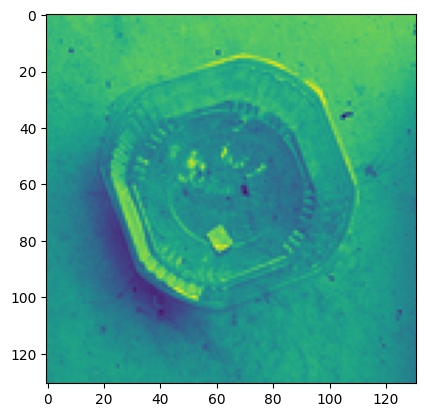

In [9]:
# verify
plt.imshow(X_train_aug[1991])

In [10]:
category_labels = {'Cardboard': 0,
 'Organics': 1,
 'Glass': 2,
 'Metal': 3,
 'Miscellaneous': 4,
 'Paper': 5,
 'Plastic': 6,
 'Textile Trash': 7,
 'Vegetation': 8}

#categories = list(category_labels.keys())
categories = category_labels # keeping it as a dict to see if it works in the confusion matrix method this way

r_categories = {v: k for k, v in categories.items()}
r_categories

{0: 'Cardboard',
 1: 'Organics',
 2: 'Glass',
 3: 'Metal',
 4: 'Miscellaneous',
 5: 'Paper',
 6: 'Plastic',
 7: 'Textile Trash',
 8: 'Vegetation'}

In [11]:
class CNNModel:
    """
    A class to manage a CNN model, along with training history and evaluation metrics.
    """
    def __init__(self, model, model_id=""):
        self.model = model
        self.model_id = model_id
        self.history = None
        self.predictions = None
        self.confusion_matrix = None
        self.cm_df = None
        self.report = None

    def fit_model(self, train_data, validation_data, epochs=12, batch_size=32, verbose=1, **kwargs):
        self.history = self.model.fit(train_data[0], 
                                      train_data[1], 
                                      validation_data=validation_data, 
                                      epochs=epochs, 
                                      batch_size=batch_size, 
                                      verbose=verbose, 
                                      **kwargs)

    def predict_data(self, data_generator):
        self.predictions = np.argmax(self.model.predict(data_generator), axis=1)

    def create_confusion_matrix(self, true_labels, class_names):
        if self.predictions is not None:
            class_indices = sorted(class_names.keys())
            self.confusion_matrix = confusion_matrix(true_labels, self.predictions, labels=class_indices)
            # needed to plot using seaborn
            self.cm_df = pd.DataFrame(self.confusion_matrix, index=[class_names[i] for i in class_indices], columns=[class_names[i] for i in class_indices])
            sn.heatmap(self.cm_df, annot=True, fmt="d")
            sn.heatmap(self.cm_df, annot=True, fmt="d")
            plt.title("Confusion Matrix") # Added a title for clarity
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.show()
            
    def get_classification_report(self, true_labels, target_names):
        if self.predictions is not None:
            self.report = classification_report(true_labels, self.predictions, target_names=target_names)
            print(self.report)
    
    def plot_training_accuracy(self):
        if self.history:
            acc = self.history.history['accuracy']
            val_acc = self.history.history['val_accuracy']
            epochs = range(1, len(acc) + 1)
            plt.plot(epochs, acc, label="Training Accuracy")
            plt.plot(epochs, val_acc, label="Validation Accuracy")
            plt.ylabel("Accuracy")
            plt.xlabel("Epochs")
            plt.xticks(epochs)
            plt.title(f"Training and Validation Accuracy - Model: {self.model_id}")
            plt.legend()
            plt.show()
            
    def get_predicted_label_distribution(self):
        if self.predictions is not None:
            predicted_series = pd.Series(self.predictions)
            return predicted_series.value_counts()
            
    def display_misclassified_examples(self, validation_data, true_labels, class_names, num_examples=5):
        """
        Randomly selects misclassified images from the validation set and displays them
        with their predicted and true labels.
        """
        if self.predictions is None:
            print("Model contains no predict values, invoke predict_data() method first.")
            return

        X_test, y_test = validation_data
        misclassified_indices = np.where(self.predictions != true_labels)[0]

        # this is never, ever going to happen
        if not misclassified_indices.size:
            print("No misclassified examples found in the validation set.")
            return

        # Invert the class_names dictionary to map indices to names
        inverted_class_names = {v: k for k, v in class_names.items()}
        num_to_show = min(num_examples, misclassified_indices.size)
        random_indices = random.sample(list(misclassified_indices), num_to_show)

        num_cols = 4
        num_rows = (num_to_show + num_cols - 1) // num_cols  # Calculate the number of rows needed

        plt.figure(figsize=(12, 3 * num_rows))  # Adjust figure height based on the number of rows
        for i, index in enumerate(random_indices):
            plt.subplot(num_rows, num_cols, i + 1)
            plt.imshow(X_test[index])
            predicted_class_index = self.predictions[index]
            true_class_index = true_labels[index]
            predicted_class_name = inverted_class_names.get(predicted_class_index, f"Unknown Pred: {predicted_class_index}")
            true_class_name = inverted_class_names.get(true_class_index, f"Unknown True: {true_class_index}")
            plt.title(f"P: {predicted_class_name}\nT: {true_class_name}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
       

In [12]:
# revision to rotate histogram, arrange graphs

def run_cnn_variability(model_builder, X_train_data, y_train_labels, X_val_data, y_val_labels, num_runs=5, epochs_per_run=10, batch_size=32):
    """
    A function that fits a CNN (to be expanded to more general models) repeatedly, to track variability
    across fitting runs.
    Needs work.
    """

    
    all_runs_metrics_df = pd.DataFrame() # To store all epoch metrics from all runs
    final_val_accuracies = []            # To store only final validation accuracies for summary plots
    all_history_data = {}
    
    print(f"Starting CNN Variability Study for {num_runs} runs, {epochs_per_run} epochs each.")
    
    # modification: when I apply a kernel interrupt, I want to get graphs from the fits that have been run so far
    
    try:
        for i in range(num_runs):
            print(f"Running Iteration {i+1}/{num_runs}...")

            # fix for GPU cache issues
            tf.keras.backend.clear_session()
            gc.collect
            
            # MUST HAVE a new model instance for each run to initialize weights
        
            model = model_builder() 
        
    
            history = model.fit(X_train_data, y_train_labels,
                                epochs=epochs_per_run,
                                validation_data=(X_val_data, y_val_labels),
                                batch_size=batch_size,
                                verbose=0) 
    
            history_df = pd.DataFrame(history.history)
            history_df['run_num'] = i + 1
            history_df['epoch'] = history_df.index + 1 # Add epoch number (starts from 1)
            all_history_data[f'run_{i+1}_history'] = history.history
        
       
            history_df.rename(columns={
                'accuracy': 'train_accuracy',
                'loss': 'train_loss',
                'val_accuracy': 'val_accuracy',
                'val_loss': 'val_loss'
            }, inplace=True)
        
            all_runs_metrics_df = pd.concat([all_runs_metrics_df, history_df], ignore_index=True)
        
            # Store the final validation accuracy for summary statistics plots
            final_val_accuracies.append(history_df['val_accuracy'].iloc[-1])

            
            
            print(f"  Run {i+1}/{num_runs} completed. Final Validation Accuracy: {history_df['val_accuracy'].iloc[-1]:.4f}")
    
    except KeyboardInterrupt:
        print(f"\nKernel interrupted.  Producing graphs and summary statistics for the {i} runs completed.")

    finally:
        print("\nSummary of results:")
        # needs to be a pd.Series, I don't understand why trying to pull directly from the df keeps failing
        final_accuracies_series = pd.Series(final_val_accuracies) 
    
        print("\nSummary Statistics of Final Validation Accuracies Across All Runs:")
        print(f"Mean: {final_accuracies_series.mean():.4f}")
        print(f"Standard Deviation: {final_accuracies_series.std():.4f}")
        print(f"Standard Error: {final_accuracies_series.std()/np.sqrt(num_runs):.4f}")
        print(f"Min: {final_accuracies_series.min():.4f}")
        print(f"Max: {final_accuracies_series.max():.4f}")
        print("\nIndividual Final Validation Accuracies:")
        print(final_accuracies_series.round(4))

        # Make an overlaid plot of all histories
    
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7), 
                         gridspec_kw={'width_ratios': [4, 1, 1]})

        # alpha levels might need some tinkering yet, needs testing
        alphamin=0.1
        alphamax=0.9
        alphad = 1.5
        alphac = alphad/num_runs    # maybe change to i+1?
        if alphac < alphamin:
            alphac = alphamin
        elif alphac > alphamax:
            alphac = alphamax
        else:
            pass

    
        for i in range(num_runs):
            history_dict = all_history_data[f'run_{i+1}_history']
            epochs_range = range(1, epochs_per_run + 1)
        
   
            axes[0].plot(epochs_range, history_dict['accuracy'], 
                     # Only add label in the first run (i == 0)
                     label='Training Accuracy (Blue)' if i == 0 else '_nolegend_', 
                     alpha=alphac, linestyle='-', color='blue')         

            axes[0].plot(epochs_range, history_dict['val_accuracy'], 
                     label='Validation Accuracy (Orange)' if i == 0 else '_nolegend_', 
                     alpha=alphac, linestyle='-', color='orange') 

        axes[0].set_title(f'Training and Validation Accuracy Across {num_runs} Runs')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Accuracy')
        axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
        axes[0].grid(True)
        #plt.tight_layout() 
        #plt.show()
    
    

    
        # more figures

        # rotated histogram... 
        sn.histplot(y=final_accuracies_series, bins=5, kde=True, color='skyblue', ax=axes[1])
        axes[1].set_title('Distribution of Final Validation Accuracies')
        axes[1].set_xlabel('Frequency of Runs')
        axes[1].set_ylabel('Final Validation Accuracy')
        axes[1].grid(axis='x', linestyle='--', alpha=0.7)

        # boxplot
        sn.boxplot(y=final_accuracies_series, color='lightgreen', ax=axes[2])
        axes[2].set_title('Box Plot of Final Validation Accuracies')
        axes[2].set_ylabel('Final Validation Accuracy')
        axes[2].grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

    return all_runs_metrics_df


In [13]:
# this is a basic CNN design that performed relatively well in the modeling notebook - "CNN_model_4"
# let's start with learning_rate 0.001, as in that notebook

def generate_cnn_1(input_shape=(131, 131, 1), num_classes=9, learning_rate=0.001):
    
    model = keras.Sequential([
        Conv2D(128,(3,3),padding='same',activation='relu',input_shape=(131,131,1)),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512,activation='relu'),
        Dense(256,activation='relu'),
        Dense(512,activation='relu'),
        Dropout(0.2),
        Dense(256,activation='relu'),
        Dropout(0.2),
        Dense(9,activation='softmax')
    ])
    # Compile 
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model



Starting CNN Variability Study for 16 runs, 12 epochs each.
Running Iteration 1/16...


2025-08-13 17:39:58.119124: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-08-13 17:39:59.645209: I external/local_xla/xla/service/service.cc:168] XLA service 0x7bc5ac010320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-13 17:39:59.645237: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-08-13 17:39:59.648826: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755106799.696423    6151 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  Run 1/16 completed. Final Validation Accuracy: 0.1703
Running Iteration 2/16...
  Run 2/16 completed. Final Validation Accuracy: 0.1714
Running Iteration 3/16...
  Run 3/16 completed. Final Validation Accuracy: 0.3123
Running Iteration 4/16...
  Run 4/16 completed. Final Validation Accuracy: 0.1756
Running Iteration 5/16...
  Run 5/16 completed. Final Validation Accuracy: 0.1703
Running Iteration 6/16...
  Run 6/16 completed. Final Validation Accuracy: 0.1725
Running Iteration 7/16...
  Run 7/16 completed. Final Validation Accuracy: 0.1703
Running Iteration 8/16...
  Run 8/16 completed. Final Validation Accuracy: 0.1703
Running Iteration 9/16...
  Run 9/16 completed. Final Validation Accuracy: 0.1703
Running Iteration 10/16...
  Run 10/16 completed. Final Validation Accuracy: 0.1746
Running Iteration 11/16...
  Run 11/16 completed. Final Validation Accuracy: 0.1703
Running Iteration 12/16...
  Run 12/16 completed. Final Validation Accuracy: 0.1703
Running Iteration 13/16...
  Run 13/

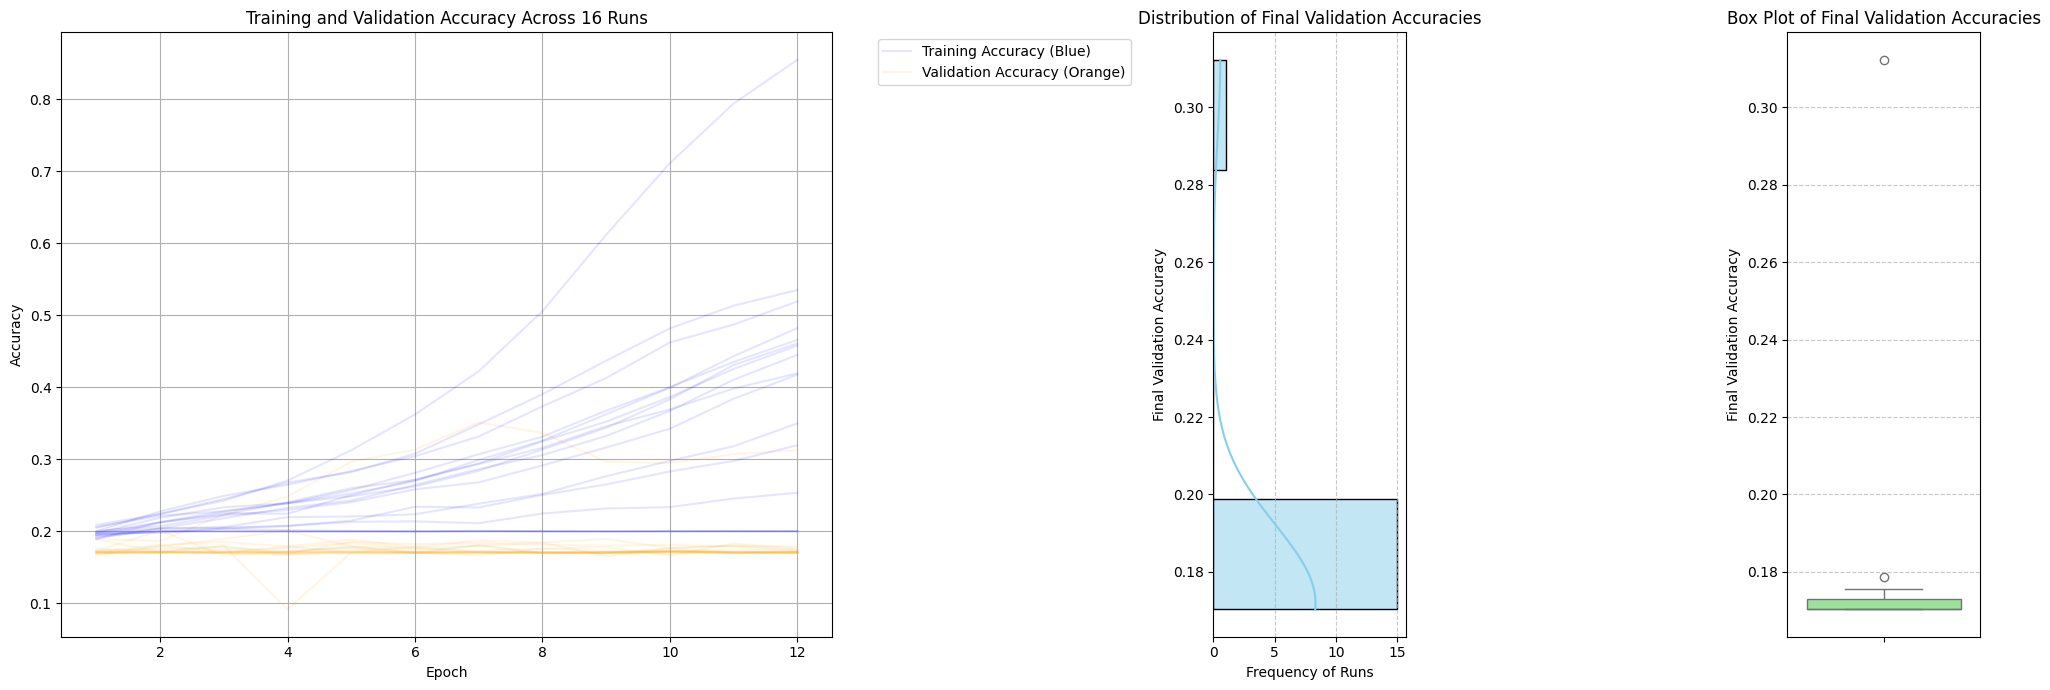

In [14]:
study_results_df_1 = run_cnn_variability(
    model_builder=generate_cnn_1,
    X_train_data=X_train_aug,
    y_train_labels=y_train_aug,
    X_val_data=X_test,
    y_val_labels=y_test,
    num_runs=16,
    epochs_per_run=12,
    batch_size=8
    )
#print("\nDataFrame with all run details:")
#print(study_results_df_1.head())

This is hardly encouraging. Of our 16 runs, only _one_ can be said to have "learned" much of anything.  All others were failing in the same manner as observed in notebook 02:  note how many accuracies are _exactly_ 0.1703.  This is of course the relative frequency of the modal class in the test set; in these training runs, the model is predicting everything to be plastic, as was seen commonly in the preceding notebook.  Several of the other results are minor variations on this theme - models that have only barely discerned, occasionally, how to discriminate between plastic and non-plastic.

One strong possibility is that the training parameters, which were consistent across the entire preceding notebook, need to be optimized a little better.  I'm going to start by changing the learning rate.

In [14]:
# same basic design with learning_rate=0.002


def generate_cnn_2(input_shape=(131, 131, 1), num_classes=9, learning_rate=0.002):
    
    model = keras.Sequential([
        Conv2D(128,(3,3),padding='same',activation='relu',input_shape=(131,131,1)),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512,activation='relu'),
        Dense(256,activation='relu'),
        Dense(512,activation='relu'),
        Dropout(0.2),
        Dense(256,activation='relu'),
        Dropout(0.2),
        Dense(9,activation='softmax')
    ])
    
    
    # Compile 
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model



Starting CNN Variability Study for 16 runs, 12 epochs each.
Running Iteration 1/16...


2025-08-13 19:38:56.430997: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-08-13 19:38:57.979835: I external/local_xla/xla/service/service.cc:168] XLA service 0x77adf4003600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-13 19:38:57.979865: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-08-13 19:38:57.984775: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755113938.033792   24464 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  Run 1/16 completed. Final Validation Accuracy: 0.1703
Running Iteration 2/16...
  Run 2/16 completed. Final Validation Accuracy: 0.1703
Running Iteration 3/16...
  Run 3/16 completed. Final Validation Accuracy: 0.1703
Running Iteration 4/16...
  Run 4/16 completed. Final Validation Accuracy: 0.1703
Running Iteration 5/16...
  Run 5/16 completed. Final Validation Accuracy: 0.1703
Running Iteration 6/16...
  Run 6/16 completed. Final Validation Accuracy: 0.1703
Running Iteration 7/16...
  Run 7/16 completed. Final Validation Accuracy: 0.1703
Running Iteration 8/16...
  Run 8/16 completed. Final Validation Accuracy: 0.1703
Running Iteration 9/16...
  Run 9/16 completed. Final Validation Accuracy: 0.1703
Running Iteration 10/16...
  Run 10/16 completed. Final Validation Accuracy: 0.1703
Running Iteration 11/16...
  Run 11/16 completed. Final Validation Accuracy: 0.1703
Running Iteration 12/16...
  Run 12/16 completed. Final Validation Accuracy: 0.1703
Running Iteration 13/16...
  Run 13/

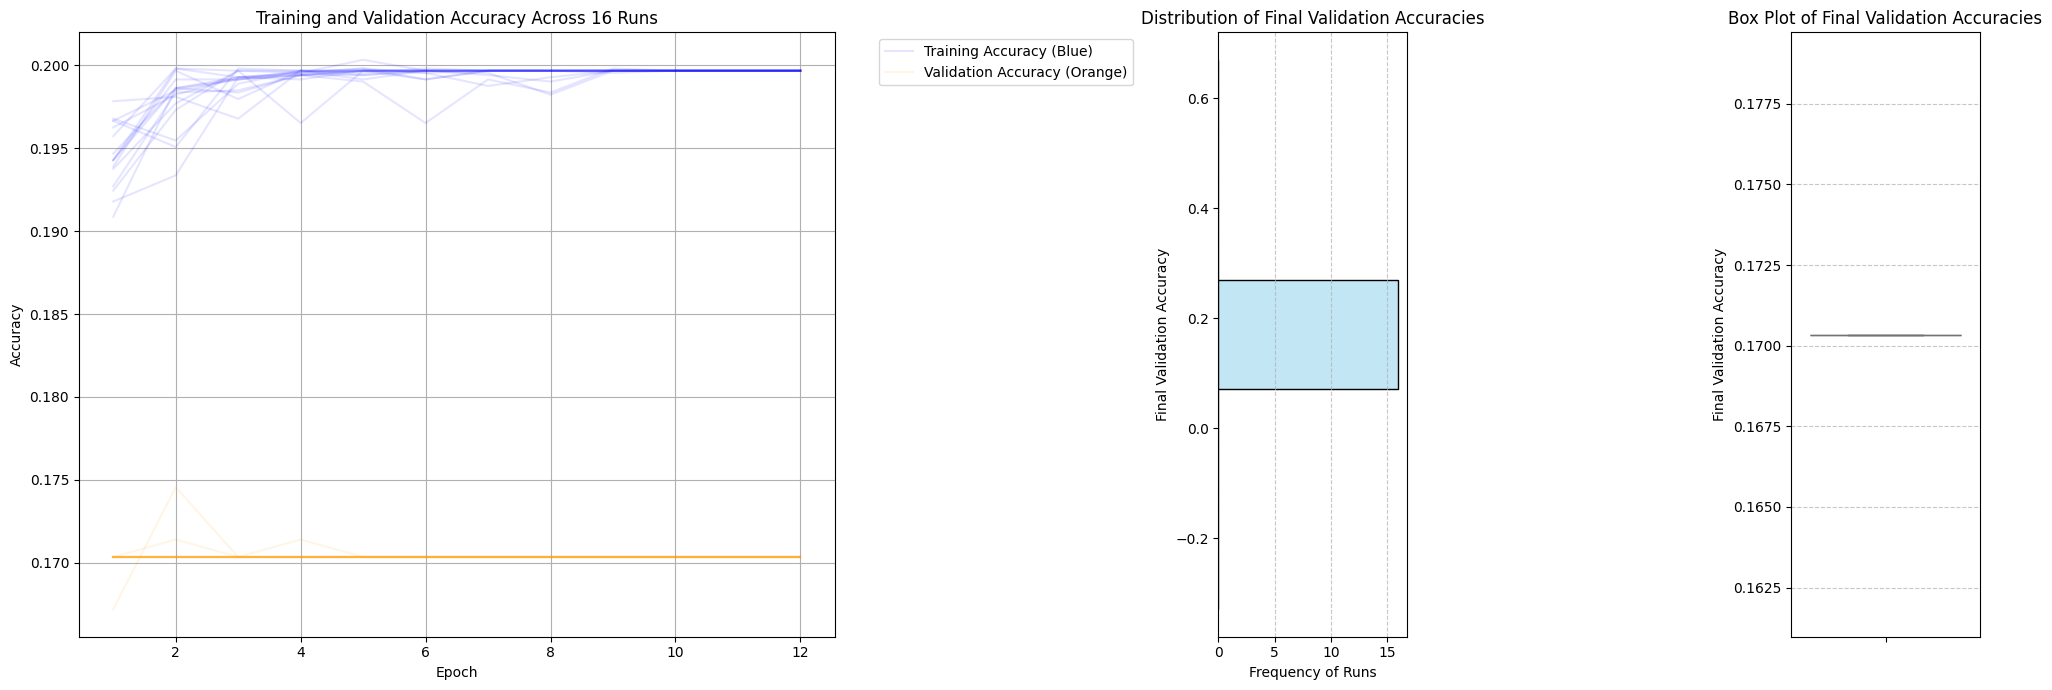

In [15]:

study_results_df_2 = run_cnn_variability(
    model_builder=generate_cnn_2,
    X_train_data=X_train_aug,
    y_train_labels=y_train_aug,
    X_val_data=X_test,
    y_val_labels=y_test,
    num_runs=16,
    epochs_per_run=12,
    batch_size=8
    )


This sequence of model trainings is certainly not a success, but the way in which it fails is instructive.  Having increased the learning rate from 0.001 (the default) to 0.002, suddenly there is _no_ deviation from the "everything is plastic" model, with accuracy 0.1703.  The fact that the problem got worse suggests that the learning rate wasn't too low, but _too high_.

Let's see what happens when instead of doubling the default learning rate, we cut it in half.

In [13]:
# same basic design but learning rate of 0.0005


def generate_cnn_3(input_shape=(131, 131, 1), num_classes=9, learning_rate=0.0005):
    
    model = keras.Sequential([
        Conv2D(128,(3,3),padding='same',activation='relu',input_shape=(131,131,1)),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512,activation='relu'),
        Dense(256,activation='relu'),
        Dense(512,activation='relu'),
        Dropout(0.2),
        Dense(256,activation='relu'),
        Dropout(0.2),
        Dense(9,activation='softmax')
    ])
    
    # Compile 
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


Starting CNN Variability Study for 16 runs, 12 epochs each.
Running Iteration 1/16...


2025-08-14 10:20:03.764810: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-08-14 10:20:05.344903: I external/local_xla/xla/service/service.cc:168] XLA service 0x7cbbac003620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-14 10:20:05.344933: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-08-14 10:20:05.353475: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755166805.412178   47364 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  Run 1/16 completed. Final Validation Accuracy: 0.3144
Running Iteration 2/16...
  Run 2/16 completed. Final Validation Accuracy: 0.3417
Running Iteration 3/16...
  Run 3/16 completed. Final Validation Accuracy: 0.2934
Running Iteration 4/16...
  Run 4/16 completed. Final Validation Accuracy: 0.1945
Running Iteration 5/16...
  Run 5/16 completed. Final Validation Accuracy: 0.3575
Running Iteration 6/16...
  Run 6/16 completed. Final Validation Accuracy: 0.2660
Running Iteration 7/16...
  Run 7/16 completed. Final Validation Accuracy: 0.2744
Running Iteration 8/16...
  Run 8/16 completed. Final Validation Accuracy: 0.2776
Running Iteration 9/16...
  Run 9/16 completed. Final Validation Accuracy: 0.3113
Running Iteration 10/16...
  Run 10/16 completed. Final Validation Accuracy: 0.3365
Running Iteration 11/16...
  Run 11/16 completed. Final Validation Accuracy: 0.2723
Running Iteration 12/16...
  Run 12/16 completed. Final Validation Accuracy: 0.3523
Running Iteration 13/16...
  Run 13/

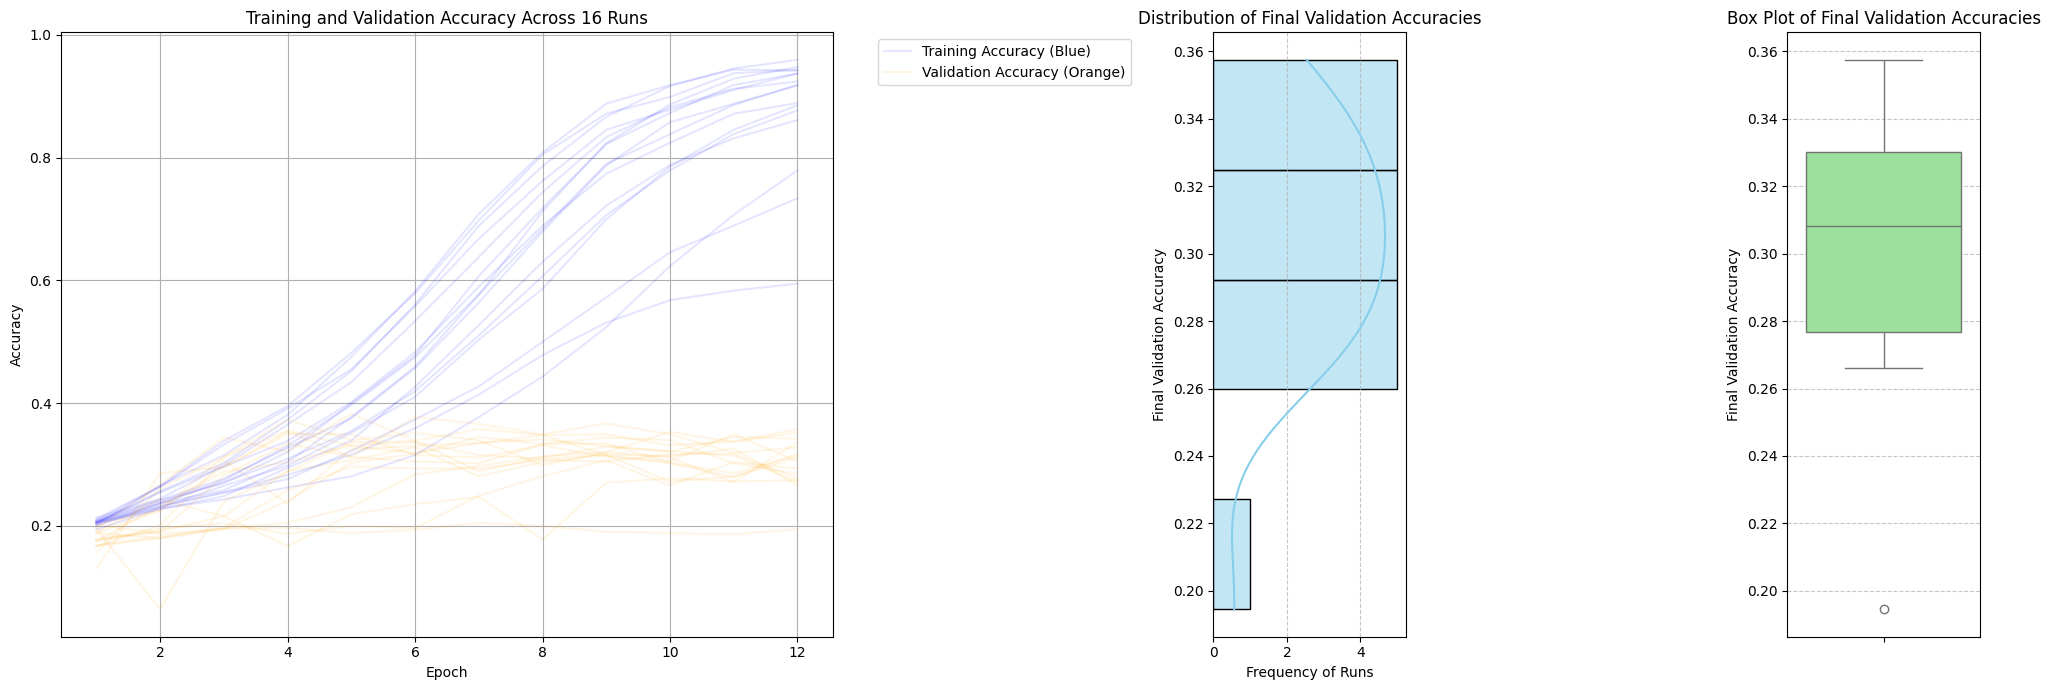

In [14]:
study_results_df_3 = run_cnn_variability(
    model_builder=generate_cnn_3,
    X_train_data=X_train_aug,
    y_train_labels=y_train_aug,
    X_val_data=X_test,
    y_val_labels=y_test,
    num_runs=16,
    epochs_per_run=12,
    batch_size=8
    )


This definitively confirms my suspicion.  The learning rate is indeed a decisive training parameter for this model, and it was indeed too high.  Of this batch of sixteen training runs, there's _not a single model_ that failed in the way that every model failed in the preceding batch!  There's plenty of variation in the results.  Indeed, without the failed models, the distribution looks _approximately_ normal.  (But note well:  "approximately" normal is a very dangerous idea.  This should be assessed far more rigorously before it's treated as a conclusion.)

This also, of course, leads to the consideration of how low the learning rate should be set.

In [13]:
def generate_cnn_4(input_shape=(131, 131, 1), num_classes=9, learning_rate=0.0002):
    
    model = keras.Sequential([
        Conv2D(128,(3,3),padding='same',activation='relu',input_shape=(131,131,1)),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512,activation='relu'),
        Dense(256,activation='relu'),
        Dense(512,activation='relu'),
        Dropout(0.2),
        Dense(256,activation='relu'),
        Dropout(0.2),
        Dense(9,activation='softmax')
    ])
   
    # Compile 
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


Starting CNN Variability Study for 16 runs, 12 epochs each.
Running Iteration 1/16...


2025-08-14 11:11:03.429197: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-08-14 11:11:04.979993: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f98e4003650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-14 11:11:04.980022: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-08-14 11:11:04.987502: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755169865.045420   65224 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  Run 1/16 completed. Final Validation Accuracy: 0.4111
Running Iteration 2/16...
  Run 2/16 completed. Final Validation Accuracy: 0.4090
Running Iteration 3/16...
  Run 3/16 completed. Final Validation Accuracy: 0.4206
Running Iteration 4/16...
  Run 4/16 completed. Final Validation Accuracy: 0.4122
Running Iteration 5/16...
  Run 5/16 completed. Final Validation Accuracy: 0.3870
Running Iteration 6/16...
  Run 6/16 completed. Final Validation Accuracy: 0.4101
Running Iteration 7/16...
  Run 7/16 completed. Final Validation Accuracy: 0.3565
Running Iteration 8/16...
  Run 8/16 completed. Final Validation Accuracy: 0.3691
Running Iteration 9/16...
  Run 9/16 completed. Final Validation Accuracy: 0.3828
Running Iteration 10/16...
  Run 10/16 completed. Final Validation Accuracy: 0.3386
Running Iteration 11/16...
  Run 11/16 completed. Final Validation Accuracy: 0.3870
Running Iteration 12/16...
  Run 12/16 completed. Final Validation Accuracy: 0.4280
Running Iteration 13/16...
  Run 13/

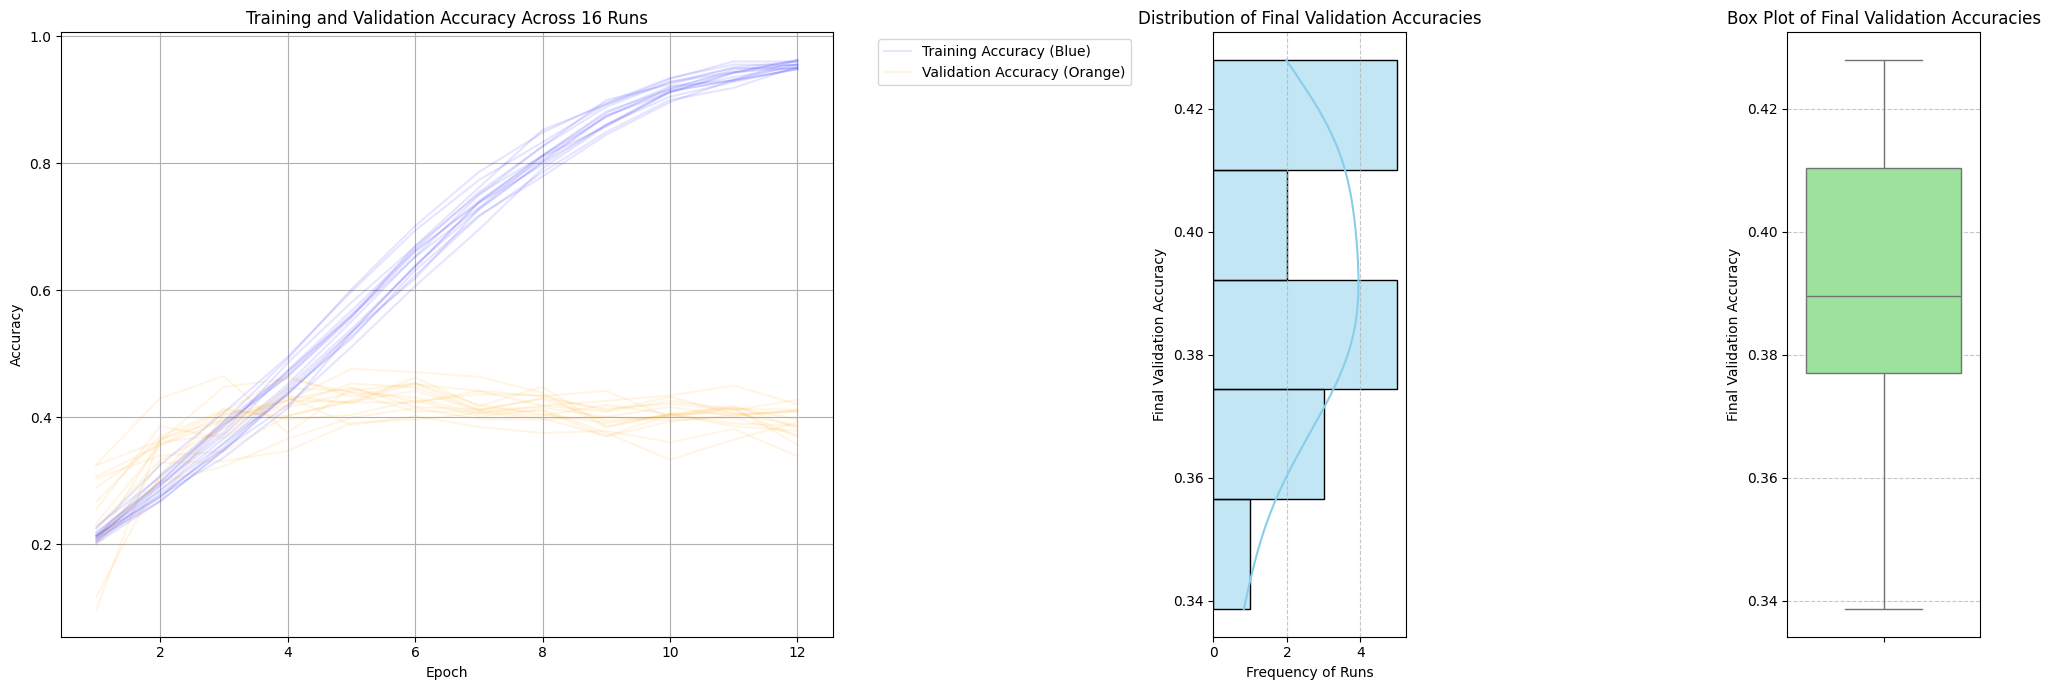

In [14]:
study_results_df_4 = run_cnn_variability(
    model_builder=generate_cnn_4,
    X_train_data=X_train_aug,
    y_train_labels=y_train_aug,
    X_val_data=X_test,
    y_val_labels=y_test,
    num_runs=16,
    epochs_per_run=12,
    batch_size=8
    )


This confirms further that the learning rate was too high; this is, probably, true across the entire prior notebook.  Dropping the learning rate to 0.0002 from 0.0005 brought the average accuracy up to 0.39 from 0.30, and dropped the standard error of the estimate from 0.0102 to 0.0061 - that's quite an improvement.  Let's see what happens if we drop the learning rate even more.

In [13]:
# 0.005

def generate_cnn_5(input_shape=(131, 131, 1), num_classes=9, learning_rate=0.0001):
    
    model = keras.Sequential([
        Conv2D(128,(3,3),padding='same',activation='relu',input_shape=(131,131,1)),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512,activation='relu'),
        Dense(256,activation='relu'),
        Dense(512,activation='relu'),
        Dropout(0.2),
        Dense(256,activation='relu'),
        Dropout(0.2),
        Dense(9,activation='softmax')
    ])
    
    # Compile 
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Starting CNN Variability Study for 16 runs, 12 epochs each.
Running Iteration 1/16...


2025-08-14 11:47:40.054882: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-08-14 11:47:41.616097: I external/local_xla/xla/service/service.cc:168] XLA service 0x7d3748003b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-14 11:47:41.616137: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-08-14 11:47:41.620075: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755172061.671392   77758 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  Run 1/16 completed. Final Validation Accuracy: 0.4742
Running Iteration 2/16...
  Run 2/16 completed. Final Validation Accuracy: 0.4974
Running Iteration 3/16...
  Run 3/16 completed. Final Validation Accuracy: 0.4658
Running Iteration 4/16...
  Run 4/16 completed. Final Validation Accuracy: 0.4669
Running Iteration 5/16...
  Run 5/16 completed. Final Validation Accuracy: 0.4858
Running Iteration 6/16...
  Run 6/16 completed. Final Validation Accuracy: 0.4732
Running Iteration 7/16...
  Run 7/16 completed. Final Validation Accuracy: 0.4469
Running Iteration 8/16...
  Run 8/16 completed. Final Validation Accuracy: 0.4637
Running Iteration 9/16...
  Run 9/16 completed. Final Validation Accuracy: 0.4805
Running Iteration 10/16...
  Run 10/16 completed. Final Validation Accuracy: 0.4679
Running Iteration 11/16...
  Run 11/16 completed. Final Validation Accuracy: 0.4532
Running Iteration 12/16...
  Run 12/16 completed. Final Validation Accuracy: 0.4574
Running Iteration 13/16...
  Run 13/

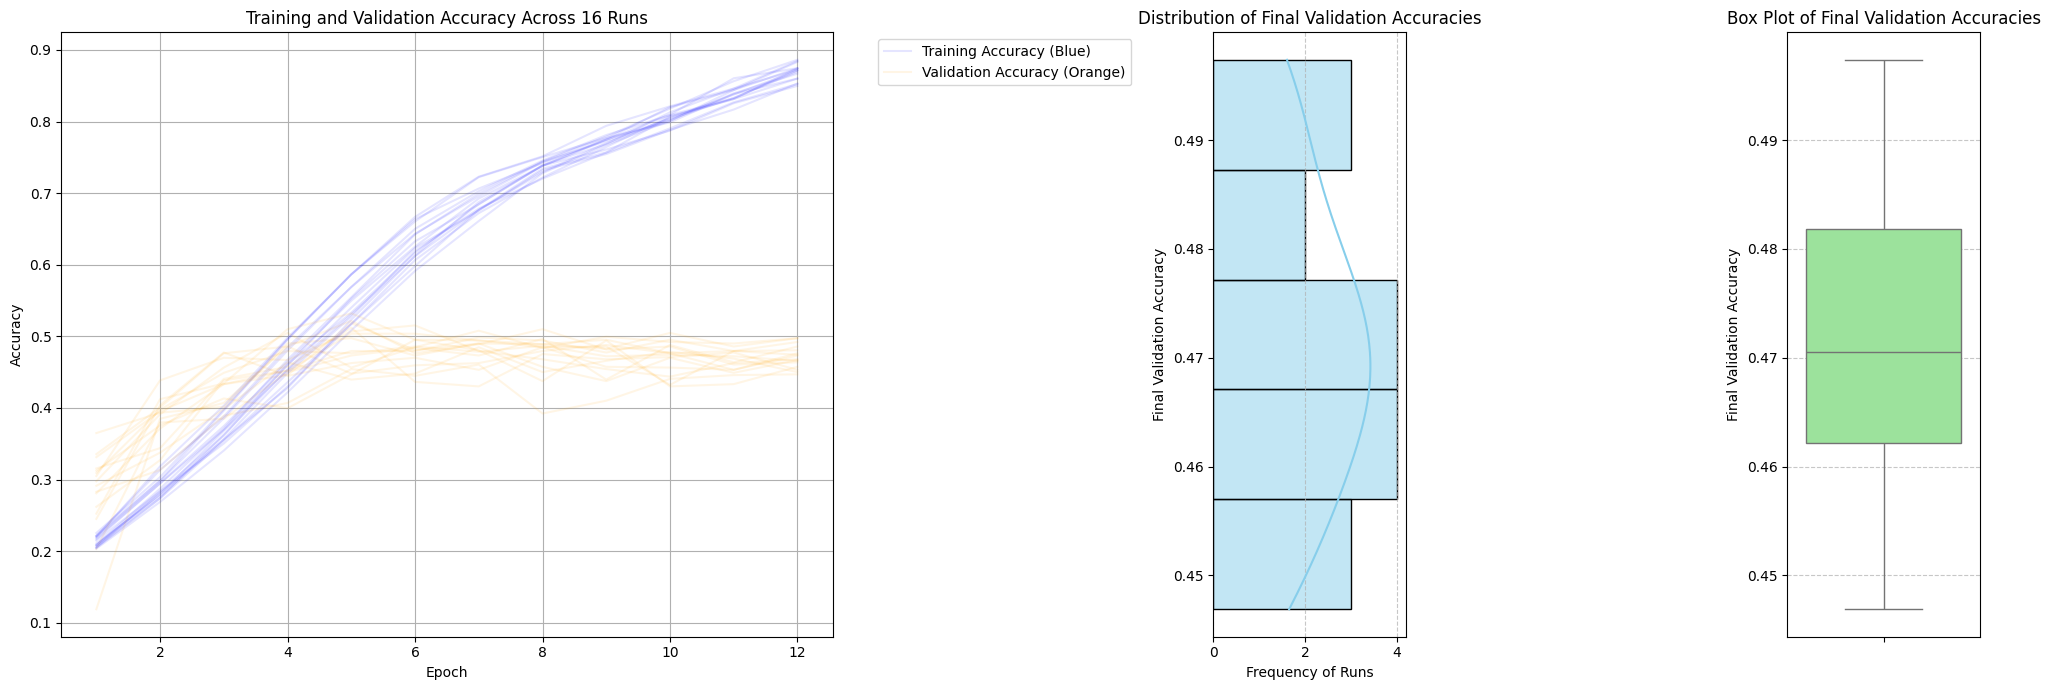

In [14]:

study_results_df_5 = run_cnn_variability(
    model_builder=generate_cnn_5,
    X_train_data=X_train_aug,
    y_train_labels=y_train_aug,
    X_val_data=X_test,
    y_val_labels=y_test,
    num_runs=16,
    epochs_per_run=12,
    batch_size=8
    )


In [13]:
# let's try an even lower learning rate

def generate_cnn_6(input_shape=(131, 131, 1), num_classes=9, learning_rate=0.00005):
    
    model = keras.Sequential([
        Conv2D(128,(3,3),padding='same',activation='relu',input_shape=(131,131,1)),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512,activation='relu'),
        Dense(256,activation='relu'),
        Dense(512,activation='relu'),
        Dropout(0.2),
        Dense(256,activation='relu'),
        Dropout(0.2),
        Dense(9,activation='softmax')
    ])
    
    # Compile 
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Starting CNN Variability Study for 16 runs, 12 epochs each.
Running Iteration 1/16...
  Run 1/16 completed. Final Validation Accuracy: 0.4942
Running Iteration 2/16...
  Run 2/16 completed. Final Validation Accuracy: 0.5089
Running Iteration 3/16...
  Run 3/16 completed. Final Validation Accuracy: 0.4784
Running Iteration 4/16...
  Run 4/16 completed. Final Validation Accuracy: 0.5058
Running Iteration 5/16...
  Run 5/16 completed. Final Validation Accuracy: 0.5079
Running Iteration 6/16...
  Run 6/16 completed. Final Validation Accuracy: 0.5205
Running Iteration 7/16...
  Run 7/16 completed. Final Validation Accuracy: 0.5089
Running Iteration 8/16...
  Run 8/16 completed. Final Validation Accuracy: 0.5510
Running Iteration 9/16...
  Run 9/16 completed. Final Validation Accuracy: 0.4974
Running Iteration 10/16...
  Run 10/16 completed. Final Validation Accuracy: 0.4858
Running Iteration 11/16...
  Run 11/16 completed. Final Validation Accuracy: 0.5100
Running Iteration 12/16...
  Run 1

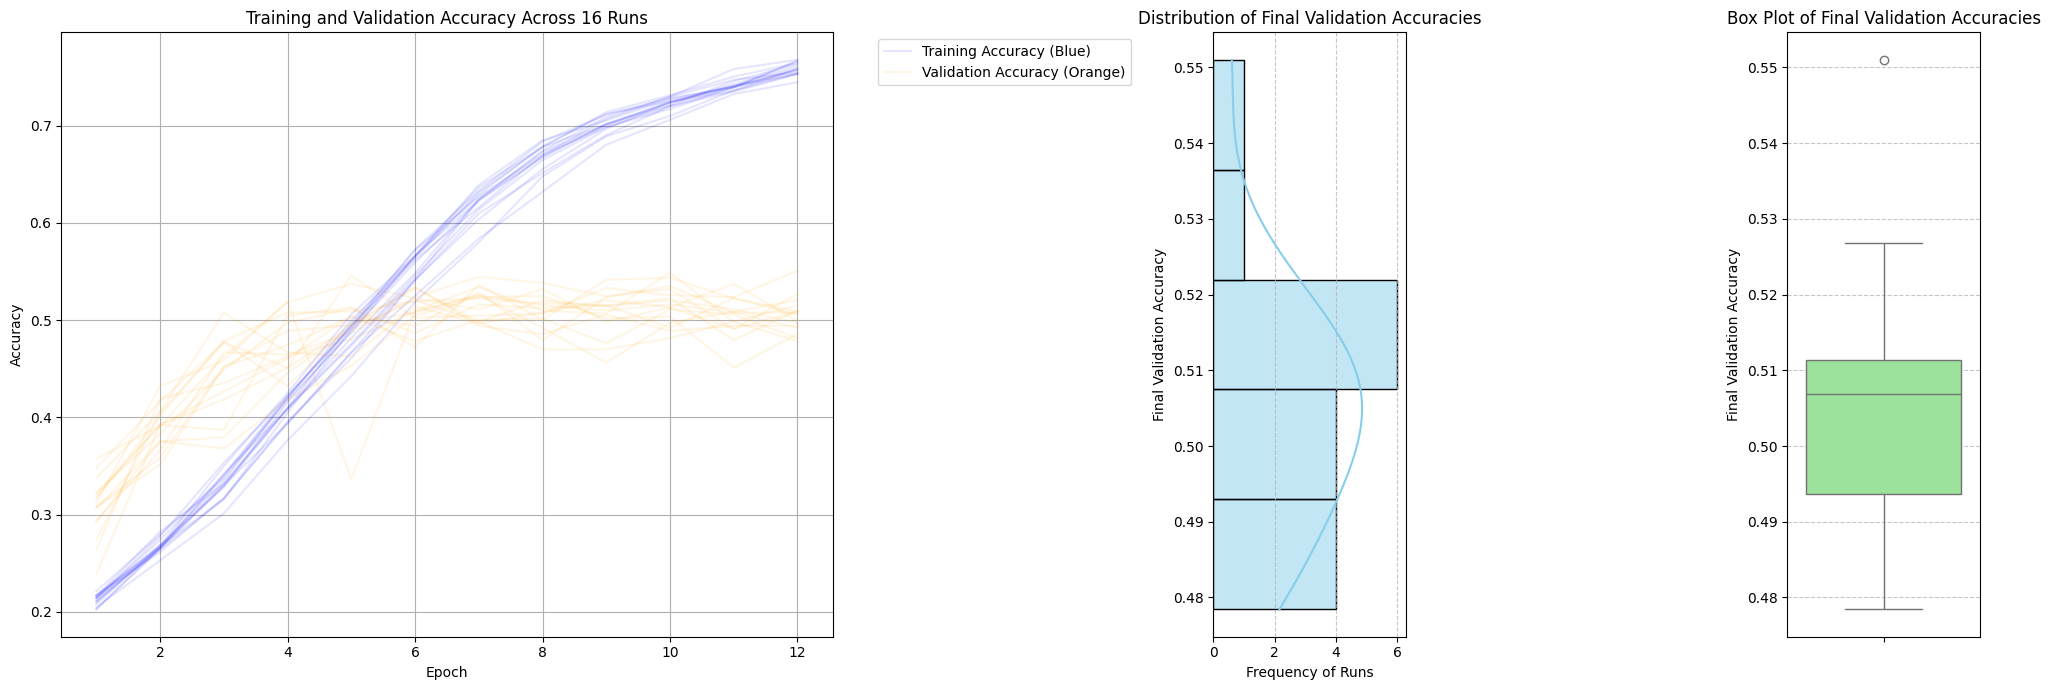

In [16]:

study_results_df_6 = run_cnn_variability(
    model_builder=generate_cnn_6,
    X_train_data=X_train_aug,
    y_train_labels=y_train_aug,
    X_val_data=X_test,
    y_val_labels=y_test,
    num_runs=16,
    epochs_per_run=12,
    batch_size=8
    )


In [13]:
# EVEN LOWER LEARNING RATE

def generate_cnn_7(input_shape=(131, 131, 1), num_classes=9, learning_rate=0.00001):
    
    model = keras.Sequential([
        Conv2D(128,(3,3),padding='same',activation='relu',input_shape=(131,131,1)),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512,activation='relu'),
        Dense(256,activation='relu'),
        Dense(512,activation='relu'),
        Dropout(0.2),
        Dense(256,activation='relu'),
        Dropout(0.2),
        Dense(9,activation='softmax')
    ])
    
    # Compile 
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model



Starting CNN Variability Study for 16 runs, 12 epochs each.
Running Iteration 1/16...


2025-08-14 12:58:56.010097: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-08-14 12:58:57.485970: I external/local_xla/xla/service/service.cc:168] XLA service 0x70dbc4010a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-14 12:58:57.486000: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-08-14 12:58:57.489501: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755176337.533861  103306 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  Run 1/16 completed. Final Validation Accuracy: 0.5436
Running Iteration 2/16...
  Run 2/16 completed. Final Validation Accuracy: 0.5184
Running Iteration 3/16...
  Run 3/16 completed. Final Validation Accuracy: 0.4921
Running Iteration 4/16...
  Run 4/16 completed. Final Validation Accuracy: 0.5279
Running Iteration 5/16...
  Run 5/16 completed. Final Validation Accuracy: 0.5184
Running Iteration 6/16...
  Run 6/16 completed. Final Validation Accuracy: 0.5174
Running Iteration 7/16...
  Run 7/16 completed. Final Validation Accuracy: 0.5331
Running Iteration 8/16...
  Run 8/16 completed. Final Validation Accuracy: 0.5384
Running Iteration 9/16...
  Run 9/16 completed. Final Validation Accuracy: 0.5226
Running Iteration 10/16...
  Run 10/16 completed. Final Validation Accuracy: 0.5068
Running Iteration 11/16...
  Run 11/16 completed. Final Validation Accuracy: 0.5310
Running Iteration 12/16...
  Run 12/16 completed. Final Validation Accuracy: 0.5310
Running Iteration 13/16...
  Run 13/

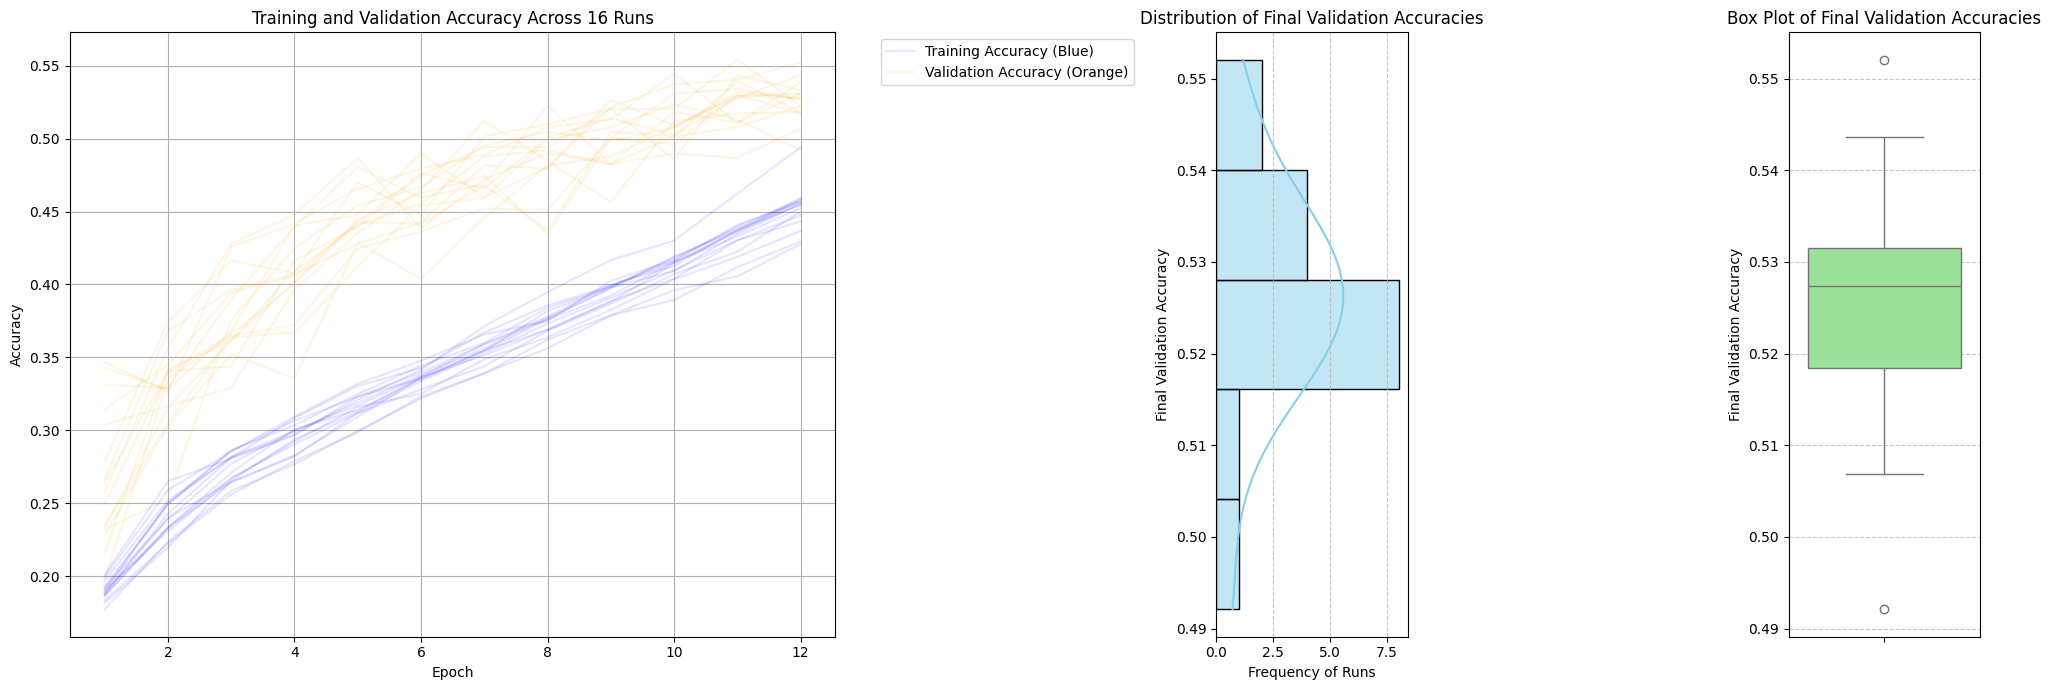

In [14]:
study_results_df_7 = run_cnn_variability(
    model_builder=generate_cnn_7,
    X_train_data=X_train_aug,
    y_train_labels=y_train_aug,
    X_val_data=X_test,
    y_val_labels=y_test,
    num_runs=16,
    epochs_per_run=12,
    batch_size=8
    )


In [13]:
# EVEN LOWER - NOW AT E-06

def generate_cnn_8(input_shape=(131, 131, 1), num_classes=9, learning_rate=0.000001):
    
    model = keras.Sequential([
        Conv2D(128,(3,3),padding='same',activation='relu',input_shape=(131,131,1)),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512,activation='relu'),
        Dense(256,activation='relu'),
        Dense(512,activation='relu'),
        Dropout(0.2),
        Dense(256,activation='relu'),
        Dropout(0.2),
        Dense(9,activation='softmax')
    ])
    
    # Compile the model with a specified optimizer and metrics
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Starting CNN Variability Study for 16 runs, 12 epochs each.
Running Iteration 1/16...


2025-08-14 13:29:52.600111: I external/local_xla/xla/service/service.cc:168] XLA service 0x35911ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-14 13:29:52.600147: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-08-14 13:29:52.606255: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755178192.657431  115787 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  Run 1/16 completed. Final Validation Accuracy: 0.4143
Running Iteration 2/16...
  Run 2/16 completed. Final Validation Accuracy: 0.4164
Running Iteration 3/16...
  Run 3/16 completed. Final Validation Accuracy: 0.4248
Running Iteration 4/16...
  Run 4/16 completed. Final Validation Accuracy: 0.4416
Running Iteration 5/16...
  Run 5/16 completed. Final Validation Accuracy: 0.4259
Running Iteration 6/16...
  Run 6/16 completed. Final Validation Accuracy: 0.4185
Running Iteration 7/16...
  Run 7/16 completed. Final Validation Accuracy: 0.4301
Running Iteration 8/16...
  Run 8/16 completed. Final Validation Accuracy: 0.4164
Running Iteration 9/16...
  Run 9/16 completed. Final Validation Accuracy: 0.4259
Running Iteration 10/16...
  Run 10/16 completed. Final Validation Accuracy: 0.4038
Running Iteration 11/16...
  Run 11/16 completed. Final Validation Accuracy: 0.4185
Running Iteration 12/16...
  Run 12/16 completed. Final Validation Accuracy: 0.3849
Running Iteration 13/16...
  Run 13/

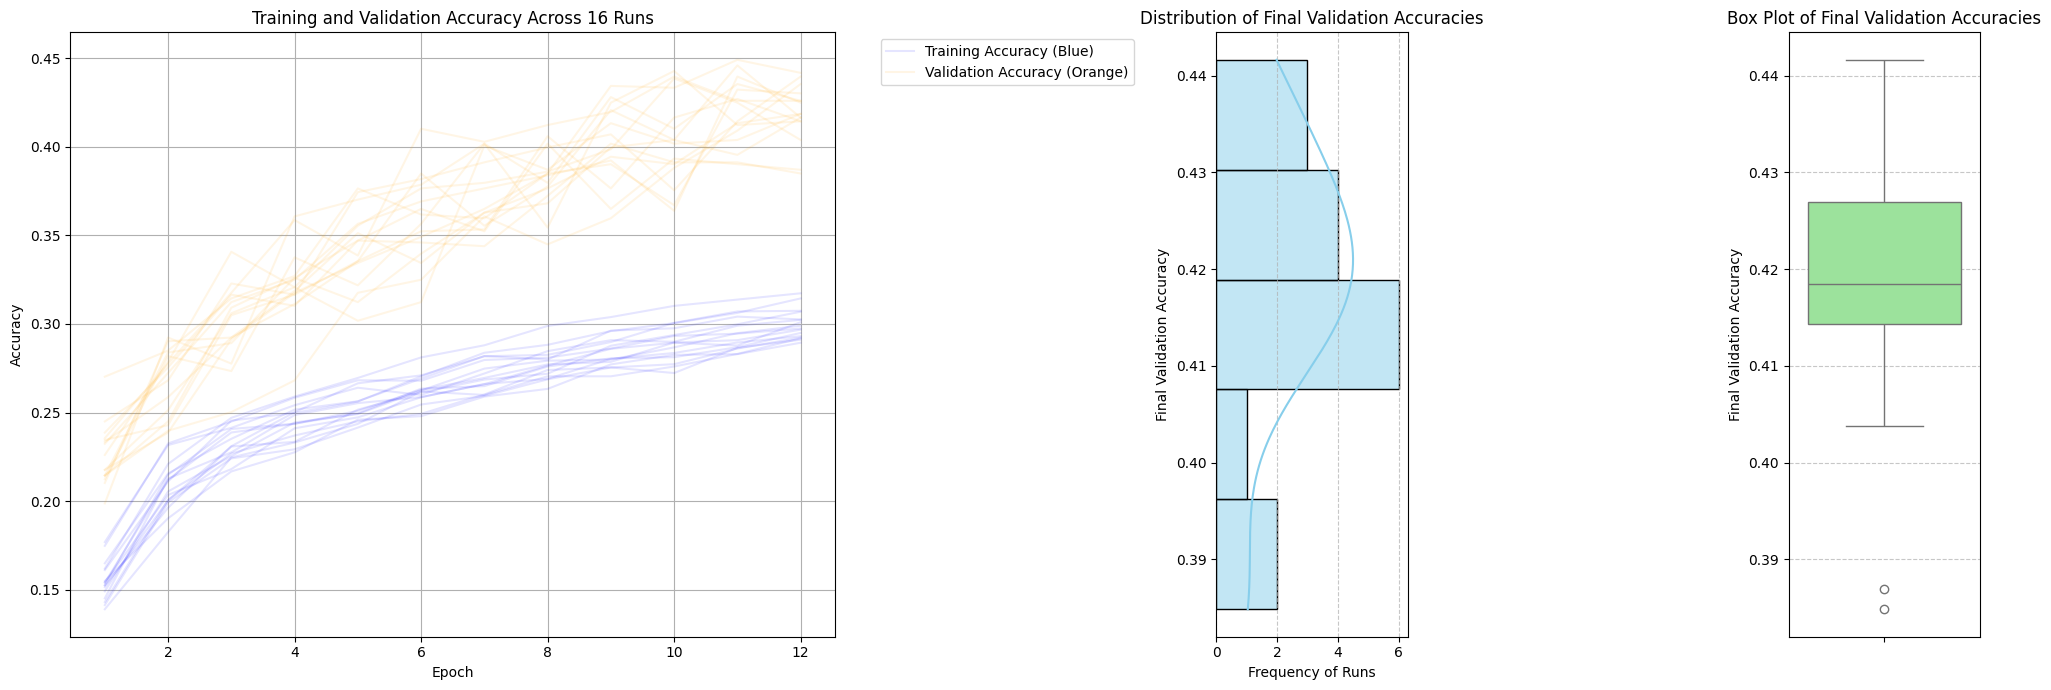

In [15]:
study_results_df_8 = run_cnn_variability(
    model_builder=generate_cnn_8,
    X_train_data=X_train_aug,
    y_train_labels=y_train_aug,
    X_val_data=X_test,
    y_val_labels=y_test,
    num_runs=16,
    epochs_per_run=12,
    batch_size=8
    )


Well, now we have a baseline for the learning rate being "too low" - our average accuracy declined from 0.5256 to 0.4186 - that's quite a substantial drop, when we look at the standard errors of these estimators.  (Do we need to do a hypothesis test here?  Although, _in general_, it could be very useful to build some hypothesis testing into this notebook.)  It would be good to estimate an "optimal" learning rate for these models on these data, and then return to the previous notebook and run _all_ the models with this new learning rate; however, I'd also like to see what happens if we go further in the wrong direction.

In [13]:
# LET'S GET A SENSE OF THE ASYMPTOTIC BEHAVIOR

def generate_cnn_9(input_shape=(131, 131, 1), num_classes=9, learning_rate=0.0000001):
    
    model = keras.Sequential([
        Conv2D(128,(3,3),padding='same',activation='relu',input_shape=(131,131,1)),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512,activation='relu'),
        Dense(256,activation='relu'),
        Dense(512,activation='relu'),
        Dropout(0.2),
        Dense(256,activation='relu'),
        Dropout(0.2),
        Dense(9,activation='softmax')
    ])
    
    # Compile the model with a specified optimizer and metrics
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Starting CNN Variability Study for 16 runs, 12 epochs each.
Running Iteration 1/16...


2025-08-14 14:13:43.607138: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-08-14 14:13:45.145294: I external/local_xla/xla/service/service.cc:168] XLA service 0x75cb70004720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-14 14:13:45.145322: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-08-14 14:13:45.148658: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755180825.194900  128387 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  Run 1/16 completed. Final Validation Accuracy: 0.2461
Running Iteration 2/16...
  Run 2/16 completed. Final Validation Accuracy: 0.2723
Running Iteration 3/16...
  Run 3/16 completed. Final Validation Accuracy: 0.2492
Running Iteration 4/16...
  Run 4/16 completed. Final Validation Accuracy: 0.2986
Running Iteration 5/16...
  Run 5/16 completed. Final Validation Accuracy: 0.2713
Running Iteration 6/16...
  Run 6/16 completed. Final Validation Accuracy: 0.2355
Running Iteration 7/16...
  Run 7/16 completed. Final Validation Accuracy: 0.2850
Running Iteration 8/16...
  Run 8/16 completed. Final Validation Accuracy: 0.2787
Running Iteration 9/16...
  Run 9/16 completed. Final Validation Accuracy: 0.2555
Running Iteration 10/16...
  Run 10/16 completed. Final Validation Accuracy: 0.2387
Running Iteration 11/16...
  Run 11/16 completed. Final Validation Accuracy: 0.2808
Running Iteration 12/16...
  Run 12/16 completed. Final Validation Accuracy: 0.2513
Running Iteration 13/16...
  Run 13/

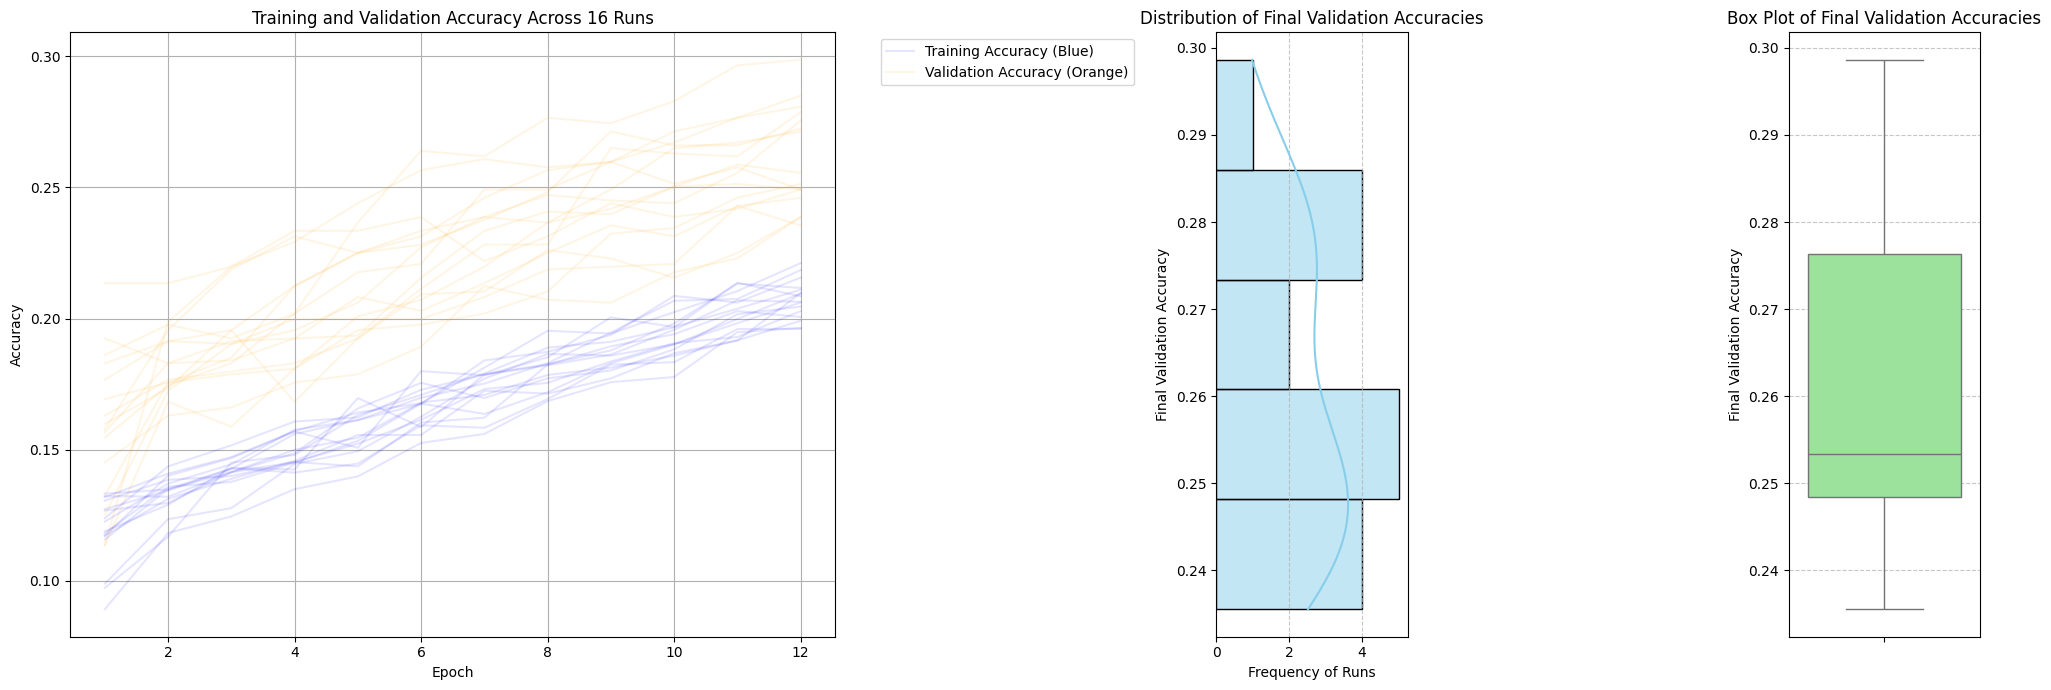

In [14]:
study_results_df_9 = run_cnn_variability(
    model_builder=generate_cnn_9,
    X_train_data=X_train_aug,
    y_train_labels=y_train_aug,
    X_val_data=X_test,
    y_val_labels=y_test,
    num_runs=16,
    epochs_per_run=12,
    batch_size=8
    )

Here we can plainly see that the learning rate is now far lower than optimal; average accuracy droppedfrom 0.42 to 0.26, and the validation accuracy across epochs looks unruly and volatile.  (I should start measuring this.)  Let's try a learning rate between 0.00001 (mean accuracy 0.5256) and 0.000001 (m.a. 0.4186) to see if we can get closer to the optimum.

In [14]:
def generate_cnn_10(input_shape=(131, 131, 1), num_classes=9, learning_rate=0.000005):
    
    model = keras.Sequential([
        Conv2D(128,(3,3),padding='same',activation='relu',input_shape=(131,131,1)),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512,activation='relu'),
        Dense(256,activation='relu'),
        Dense(512,activation='relu'),
        Dropout(0.2),
        Dense(256,activation='relu'),
        Dropout(0.2),
        Dense(9,activation='softmax')
    ])
    
    
    # Compile the model with a specified optimizer and metrics
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Starting CNN Variability Study for 16 runs, 12 epochs each.
Running Iteration 1/16...
  Run 1/16 completed. Final Validation Accuracy: 0.4921
Running Iteration 2/16...
  Run 2/16 completed. Final Validation Accuracy: 0.5026
Running Iteration 3/16...
  Run 3/16 completed. Final Validation Accuracy: 0.4795
Running Iteration 4/16...
  Run 4/16 completed. Final Validation Accuracy: 0.4932
Running Iteration 5/16...
  Run 5/16 completed. Final Validation Accuracy: 0.4732
Running Iteration 6/16...
  Run 6/16 completed. Final Validation Accuracy: 0.5184
Running Iteration 7/16...
  Run 7/16 completed. Final Validation Accuracy: 0.4742
Running Iteration 8/16...
  Run 8/16 completed. Final Validation Accuracy: 0.5068
Running Iteration 9/16...
  Run 9/16 completed. Final Validation Accuracy: 0.4700
Running Iteration 10/16...
  Run 10/16 completed. Final Validation Accuracy: 0.4953
Running Iteration 11/16...
  Run 11/16 completed. Final Validation Accuracy: 0.4921
Running Iteration 12/16...
  Run 1

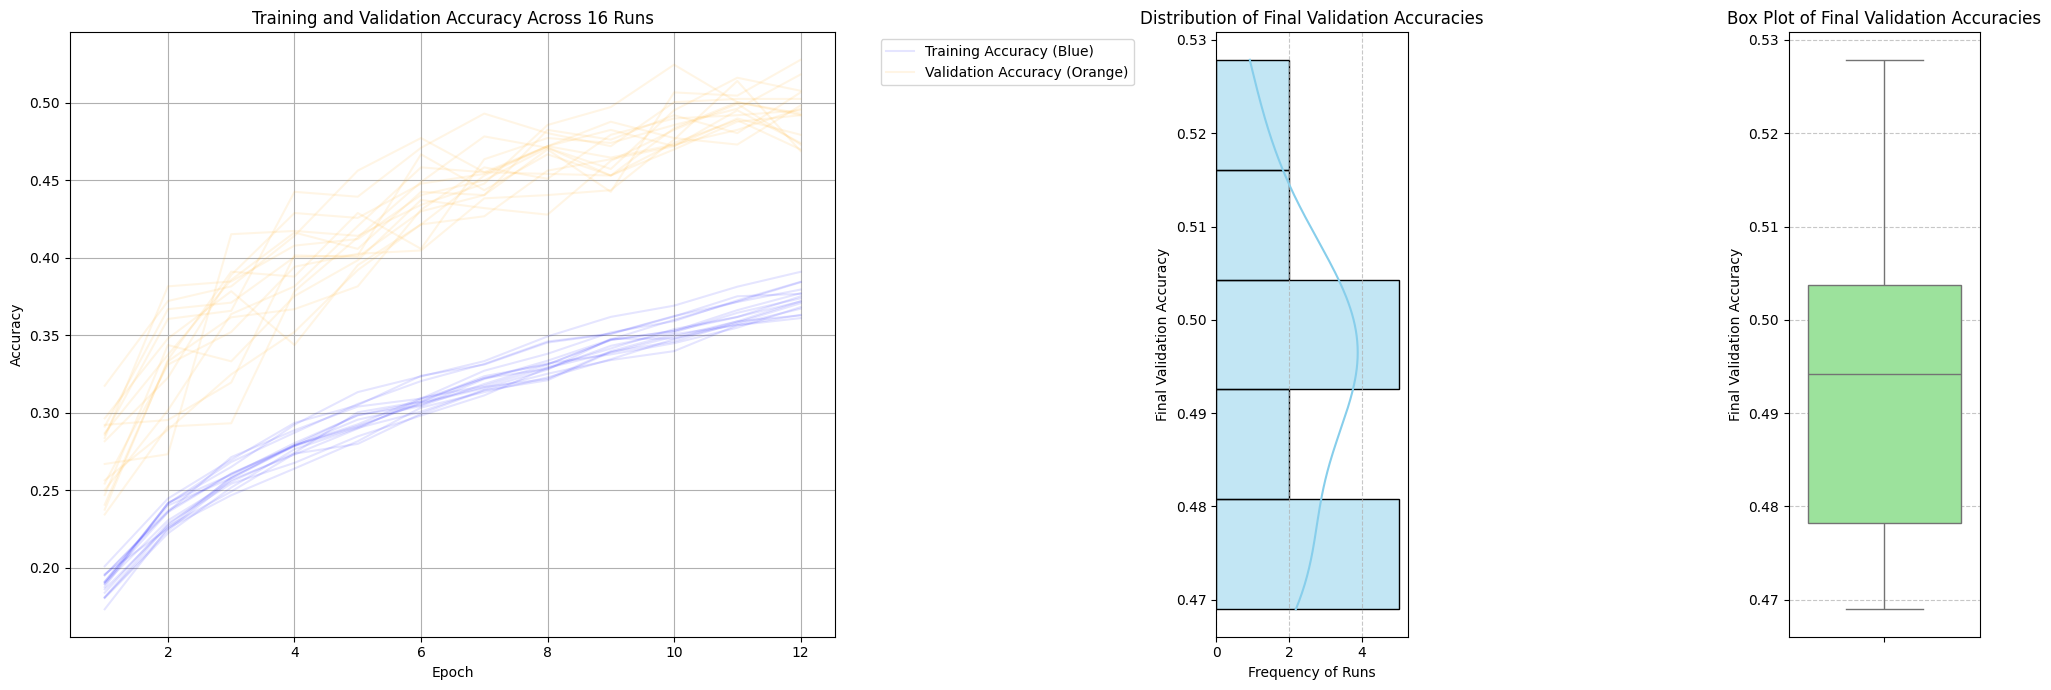

In [16]:
study_results_df_10 = run_cnn_variability(
    model_builder=generate_cnn_10,
    X_train_data=X_train_aug,
    y_train_labels=y_train_aug,
    X_val_data=X_test,
    y_val_labels=y_test,
    num_runs=16,
    epochs_per_run=12,
    batch_size=8
    )

With average accuracy of 0.4936 - less than our current best of 0.5256 - it looks like we're interpolating in the wrong direction.

In [13]:
def generate_cnn_11(input_shape=(131, 131, 1), num_classes=9, learning_rate=0.00002):
    
    model = keras.Sequential([
        Conv2D(128,(3,3),padding='same',activation='relu',input_shape=(131,131,1)),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512,activation='relu'),
        Dense(256,activation='relu'),
        Dense(512,activation='relu'),
        Dropout(0.2),
        Dense(256,activation='relu'),
        Dropout(0.2),
        Dense(9,activation='softmax')
    ])
    
    
    # Compile the model with a specified optimizer and metrics
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Starting CNN Variability Study for 16 runs, 12 epochs each.
Running Iteration 1/16...


2025-08-14 15:26:44.727784: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-08-14 15:26:46.177264: I external/local_xla/xla/service/service.cc:168] XLA service 0x7746d6bd8bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-14 15:26:46.177289: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-08-14 15:26:46.182432: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755185206.228891  153832 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  Run 1/16 completed. Final Validation Accuracy: 0.5300
Running Iteration 2/16...
  Run 2/16 completed. Final Validation Accuracy: 0.5342
Running Iteration 3/16...
  Run 3/16 completed. Final Validation Accuracy: 0.5773
Running Iteration 4/16...
  Run 4/16 completed. Final Validation Accuracy: 0.5300
Running Iteration 5/16...
  Run 5/16 completed. Final Validation Accuracy: 0.5373
Running Iteration 6/16...
  Run 6/16 completed. Final Validation Accuracy: 0.5542
Running Iteration 7/16...
  Run 7/16 completed. Final Validation Accuracy: 0.5384
Running Iteration 8/16...
  Run 8/16 completed. Final Validation Accuracy: 0.5626
Running Iteration 9/16...
  Run 9/16 completed. Final Validation Accuracy: 0.5447
Running Iteration 10/16...
  Run 10/16 completed. Final Validation Accuracy: 0.5384
Running Iteration 11/16...
  Run 11/16 completed. Final Validation Accuracy: 0.5321
Running Iteration 12/16...
  Run 12/16 completed. Final Validation Accuracy: 0.5605
Running Iteration 13/16...
  Run 13/

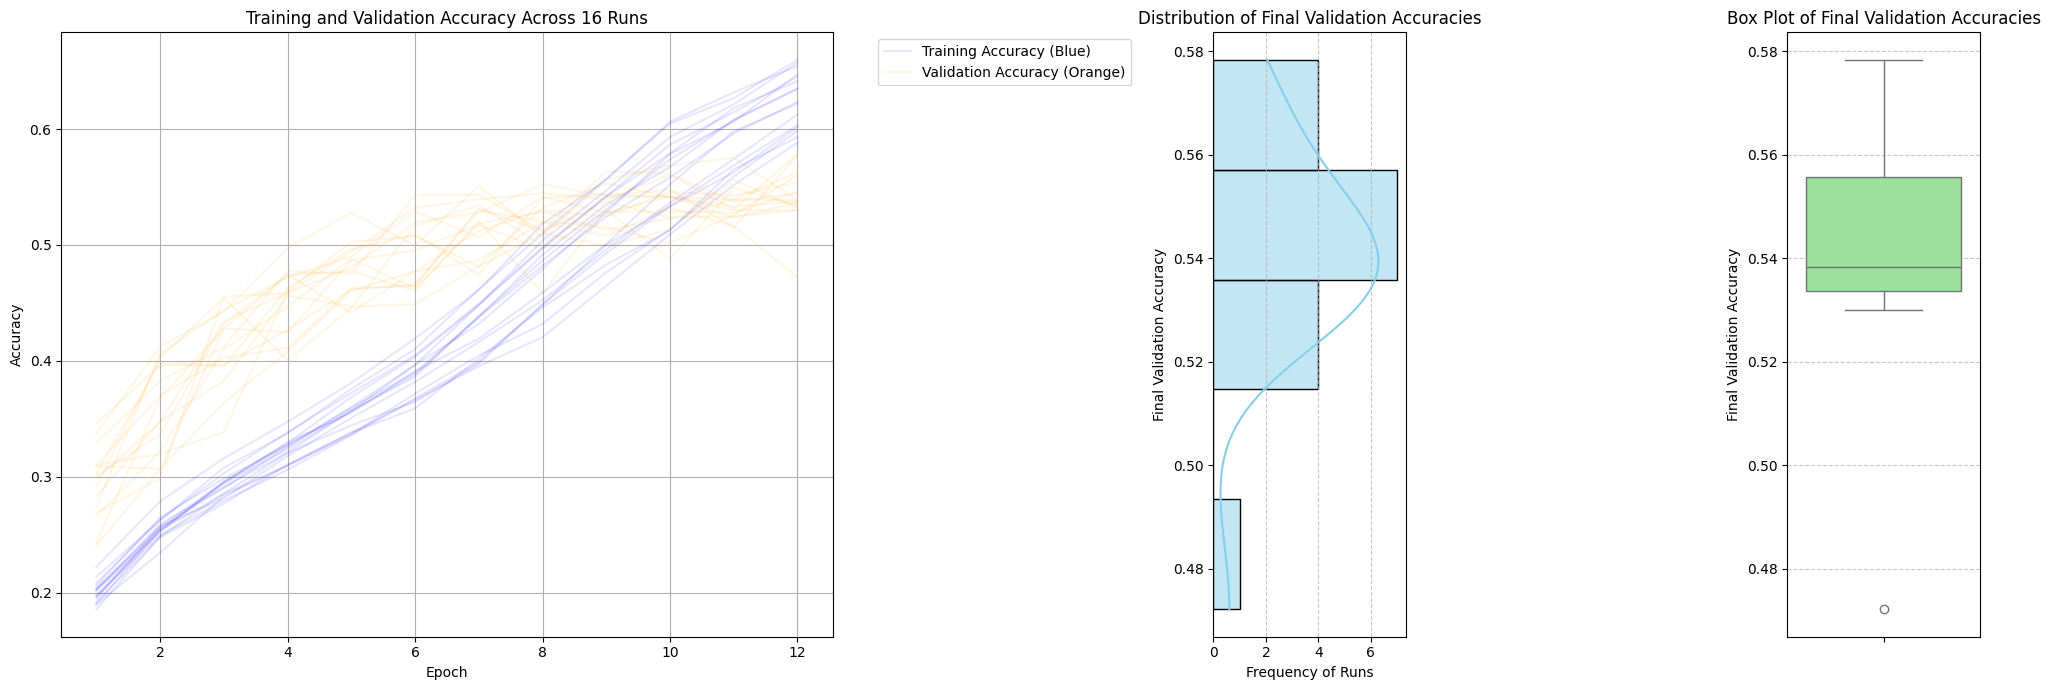

In [14]:
study_results_df_11 = run_cnn_variability(
    model_builder=generate_cnn_11,
    X_train_data=X_train_aug,
    y_train_labels=y_train_aug,
    X_val_data=X_test,
    y_val_labels=y_test,
    num_runs=16,
    epochs_per_run=12,
    batch_size=8
    )

This average accuracy of 0.5420 sets a new best for this study, as does the max of 0.5783.  Let's interpolate between 0.00001 (0.5256) and 0.0002 (0.5420)...

In [13]:
def generate_cnn_12(input_shape=(131, 131, 1), num_classes=9, learning_rate=0.000015):
    
    model = keras.Sequential([
        Conv2D(128,(3,3),padding='same',activation='relu',input_shape=(131,131,1)),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512,activation='relu'),
        Dense(256,activation='relu'),
        Dense(512,activation='relu'),
        Dropout(0.2),
        Dense(256,activation='relu'),
        Dropout(0.2),
        Dense(9,activation='softmax')
    ])
    
    # Compile the model with a specified optimizer and metrics
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Starting CNN Variability Study for 16 runs, 12 epochs each.
Running Iteration 1/16...


2025-08-14 15:57:49.894654: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-08-14 15:57:51.439354: I external/local_xla/xla/service/service.cc:168] XLA service 0x7d42f4003680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-14 15:57:51.439388: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-08-14 15:57:51.446495: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755187071.504236  166413 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  Run 1/16 completed. Final Validation Accuracy: 0.5857
Running Iteration 2/16...
  Run 2/16 completed. Final Validation Accuracy: 0.5121
Running Iteration 3/16...
  Run 3/16 completed. Final Validation Accuracy: 0.5542
Running Iteration 4/16...
  Run 4/16 completed. Final Validation Accuracy: 0.5279
Running Iteration 5/16...
  Run 5/16 completed. Final Validation Accuracy: 0.5331
Running Iteration 6/16...
  Run 6/16 completed. Final Validation Accuracy: 0.5068
Running Iteration 7/16...
  Run 7/16 completed. Final Validation Accuracy: 0.5468
Running Iteration 8/16...
  Run 8/16 completed. Final Validation Accuracy: 0.5647
Running Iteration 9/16...
  Run 9/16 completed. Final Validation Accuracy: 0.5426
Running Iteration 10/16...
  Run 10/16 completed. Final Validation Accuracy: 0.5331
Running Iteration 11/16...
  Run 11/16 completed. Final Validation Accuracy: 0.5310
Running Iteration 12/16...
  Run 12/16 completed. Final Validation Accuracy: 0.5478
Running Iteration 13/16...
  Run 13/

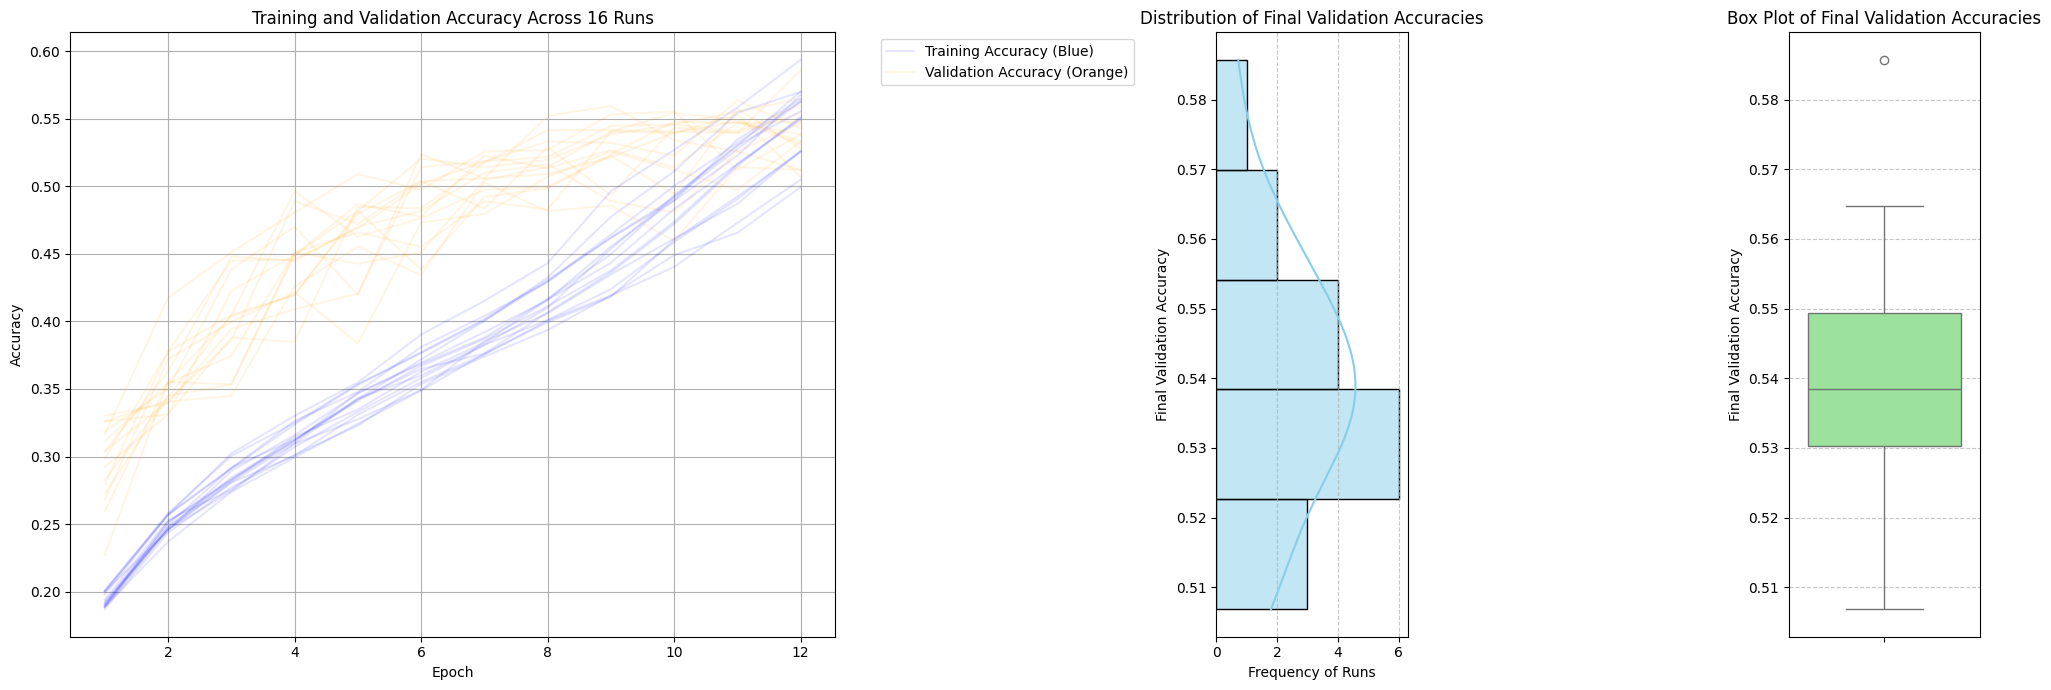

In [14]:
study_results_df_12 = run_cnn_variability(
    model_builder=generate_cnn_12,
    X_train_data=X_train_aug,
    y_train_labels=y_train_aug,
    X_val_data=X_test,
    y_val_labels=y_test,
    num_runs=16,
    epochs_per_run=12,
    batch_size=8
    )

The average accuracy of 0.5397 is the new second-highest mean; this suggests interpolating between learning rates of 0.000015 and 0.00002.

In [13]:
def generate_cnn_13(input_shape=(131, 131, 1), num_classes=9, learning_rate=0.0000175):
    
    model = keras.Sequential([
        Conv2D(128,(3,3),padding='same',activation='relu',input_shape=(131,131,1)),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Conv2D(64,(3,3),padding='same',activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512,activation='relu'),
        Dense(256,activation='relu'),
        Dense(512,activation='relu'),
        Dropout(0.2),
        Dense(256,activation='relu'),
        Dropout(0.2),
        Dense(9,activation='softmax')
    ])
    
    # Compile the model with a specified optimizer and metrics
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Starting CNN Variability Study for 16 runs, 12 epochs each.
Running Iteration 1/16...


2025-08-14 16:27:27.557313: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-08-14 16:27:29.160776: I external/local_xla/xla/service/service.cc:168] XLA service 0x7d0fdc480ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-14 16:27:29.160810: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-08-14 16:27:29.171535: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755188849.234927  178893 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  Run 1/16 completed. Final Validation Accuracy: 0.5279
Running Iteration 2/16...
  Run 2/16 completed. Final Validation Accuracy: 0.5457
Running Iteration 3/16...
  Run 3/16 completed. Final Validation Accuracy: 0.5310
Running Iteration 4/16...
  Run 4/16 completed. Final Validation Accuracy: 0.5552
Running Iteration 5/16...
  Run 5/16 completed. Final Validation Accuracy: 0.5457
Running Iteration 6/16...
  Run 6/16 completed. Final Validation Accuracy: 0.5384
Running Iteration 7/16...
  Run 7/16 completed. Final Validation Accuracy: 0.5247
Running Iteration 8/16...
  Run 8/16 completed. Final Validation Accuracy: 0.5321
Running Iteration 9/16...
  Run 9/16 completed. Final Validation Accuracy: 0.4700
Running Iteration 10/16...
  Run 10/16 completed. Final Validation Accuracy: 0.5342
Running Iteration 11/16...
  Run 11/16 completed. Final Validation Accuracy: 0.5573
Running Iteration 12/16...
  Run 12/16 completed. Final Validation Accuracy: 0.5426
Running Iteration 13/16...
  Run 13/

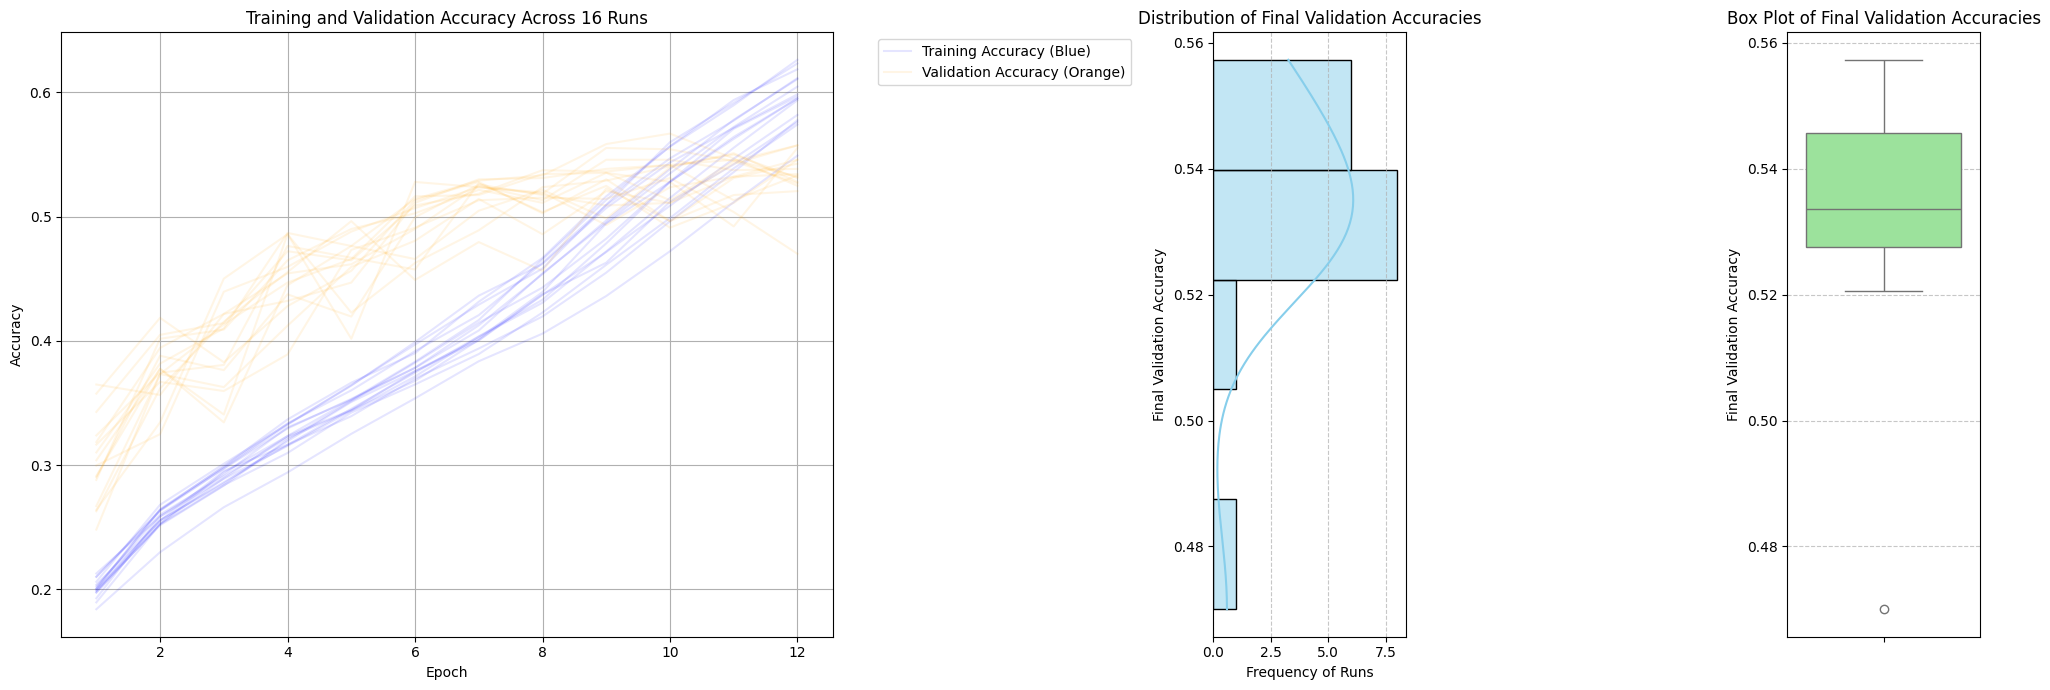

In [14]:
study_results_df_13 = run_cnn_variability(
    model_builder=generate_cnn_13,
    X_train_data=X_train_aug,
    y_train_labels=y_train_aug,
    X_val_data=X_test,
    y_val_labels=y_test,
    num_runs=16,
    epochs_per_run=12,
    batch_size=8
    )

For now, that's a good enough interpolative approximation of our optimum, and we can see that there isn't simple convexity around this maximum.  The highest averages were being found in the range 0.000015 - 0.00002, and they're very close; I'll take 0.0000175 as an improved value for revising the modeling notebook.  But let's assess these results, which, really, I should have been prepared to do all along.

In [17]:
# working this way is abysmal, yes - this initial exploratory study wasn't as well-conceived as it might have been
# a second version will automate all of this

results_data = {
    'Model_ID': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
    'Learning_Rate': [0.001, 0.002, 0.0005, 0.0002, 0.0001, 0.00005, 0.00001, 0.000001, 0.0000001, 0.000005, 0.00002, 0.000015, 0.0000175],
    'Mean': [0.1807, 0.1703, 0.3017, 0.3907, 0.4718, 0.5053, 0.5256, 0.4186, 0.2610, 0.4936, 0.5420, 0.5397, 0.5339],
    'SD': [0.0352, 0, 0.0408, 0.0243, 0.0159, 0.0182, 0.0141, 0.0162, 0.0192, 0.0172, 0.0244, 0.0207, 0.0206],
    'Min': [0.1703, 0.1703, 0.1945, 0.3386, 0.4469, 0.4784, 0.4921, 0.3849, 0.2355, 0.4690, 0.4721, 0.5068, 0.4700],
    'Max': [0.3123, 0.1703, 0.3575, 0.4280, 0.4974, 0.5510, 0.5521, 0.4416, 0.2986, 0.5279, 0.5783, 0.5857, 0.5573]
}

results = pd.DataFrame(results_data)
print(results)

    Model_ID  Learning_Rate    Mean      SD     Min     Max
0          1   1.000000e-03  0.1807  0.0352  0.1703  0.3123
1          2   2.000000e-03  0.1703  0.0000  0.1703  0.1703
2          3   5.000000e-04  0.3017  0.0408  0.1945  0.3575
3          4   2.000000e-04  0.3907  0.0243  0.3386  0.4280
4          5   1.000000e-04  0.4718  0.0159  0.4469  0.4974
5          6   5.000000e-05  0.5053  0.0182  0.4784  0.5510
6          7   1.000000e-05  0.5256  0.0141  0.4921  0.5521
7          8   1.000000e-06  0.4186  0.0162  0.3849  0.4416
8          9   1.000000e-07  0.2610  0.0192  0.2355  0.2986
9         10   5.000000e-06  0.4936  0.0172  0.4690  0.5279
10        11   2.000000e-05  0.5420  0.0244  0.4721  0.5783
11        12   1.500000e-05  0.5397  0.0207  0.5068  0.5857
12        13   1.750000e-05  0.5339  0.0206  0.4700  0.5573


In [18]:
# maybe I will want to make confidence intervals or something
# sample size was 16, so SE divides SD by 4

results['SE'] = results['SD']/4
results

,Model_ID,Learning_Rate,Mean,SD,Min,Max,SE
0,1,1.000000e-03,0.1807,0.0352,0.1703,0.3123,0.008800
1,2,2.000000e-03,0.1703,0.0000,0.1703,0.1703,0.000000
2,3,5.000000e-04,0.3017,0.0408,0.1945,0.3575,0.010200
3,4,2.000000e-04,0.3907,0.0243,0.3386,0.4280,0.006075
4,5,1.000000e-04,0.4718,0.0159,0.4469,0.4974,0.003975
5,6,5.000000e-05,0.5053,0.0182,0.4784,0.5510,0.004550
6,7,1.000000e-05,0.5256,0.0141,0.4921,0.5521,0.003525
7,8,1.000000e-06,0.4186,0.0162,0.3849,0.4416,0.004050
8,9,1.000000e-07,0.2610,0.0192,0.2355,0.2986,0.004800
9,10,5.000000e-06,0.4936,0.0172,0.4690,0.5279,0.004300


In [19]:
# let's sort these by learning rate for clarity

results=results.sort_values(by='Learning_Rate')
results

,Model_ID,Learning_Rate,Mean,SD,Min,Max,SE
8,9,1.000000e-07,0.2610,0.0192,0.2355,0.2986,0.004800
7,8,1.000000e-06,0.4186,0.0162,0.3849,0.4416,0.004050
9,10,5.000000e-06,0.4936,0.0172,0.4690,0.5279,0.004300
6,7,1.000000e-05,0.5256,0.0141,0.4921,0.5521,0.003525
11,12,1.500000e-05,0.5397,0.0207,0.5068,0.5857,0.005175
12,13,1.750000e-05,0.5339,0.0206,0.4700,0.5573,0.005150
10,11,2.000000e-05,0.5420,0.0244,0.4721,0.5783,0.006100
5,6,5.000000e-05,0.5053,0.0182,0.4784,0.5510,0.004550
4,5,1.000000e-04,0.4718,0.0159,0.4469,0.4974,0.003975
3,4,2.000000e-04,0.3907,0.0243,0.3386,0.4280,0.006075


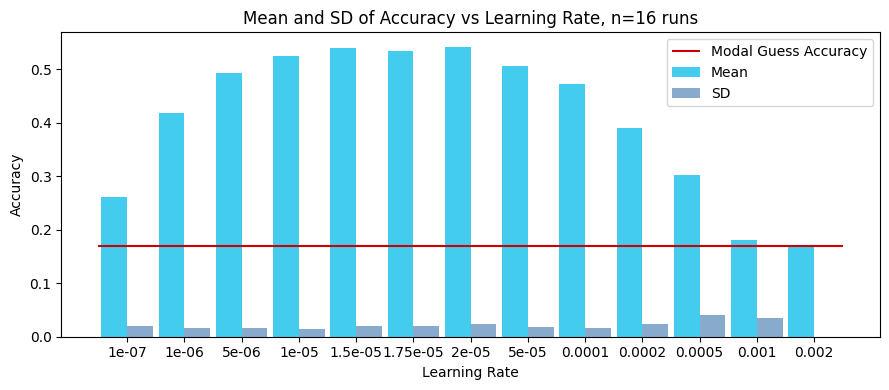

In [31]:
# starting with a simple bar graph

x_labels = results['Learning_Rate']
x = np.arange(len(x_labels))
bar_width = 0.45

fig, ax = plt.subplots(figsize=(9, 4))

bars1 = ax.bar(x - bar_width/2, results['Mean'], bar_width, label='Mean', color='#44CCEE')
bars1 = ax.bar(x + bar_width/2, results['SD'], bar_width, label='SD', color='#88AACC')

# having the 'everything is plastic' accuracy could be good
plt.hlines(y=0.1703, xmin=-0.5, xmax=len(x_labels)-0.5, colors='#CC0000', label='Modal Guess Accuracy')

ax.set_ylabel('Accuracy')
ax.set_xlabel('Learning Rate')
ax.set_title('Mean and SD of Accuracy vs Learning Rate, n=16 runs')
ax.set_xticks(x, labels=x_labels)
ax.legend()

fig.tight_layout()
plt.show()